# Rival Rush - EDA

In [1]:
pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import sys
import json
from typing import List, Dict, Union, Any  # Importiere Any
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:

def zeige_ordnerstruktur(ordner_pfad: str, einrueckung: str = "") -> None:
    """
    Zeigt die Ordnerstruktur rekursiv an, beginnend bei einem gegebenen Pfad.

    Args:
        ordner_pfad: Der Pfad des Ordners, dessen Struktur angezeigt werden soll.
        einrueckung: Ein String, der für die Einrückung der Ausgabe verwendet wird (für die Rekursion).
    """
    pfad = Path(ordner_pfad)

    if not pfad.is_dir():
        print(f"Fehler: Der Pfad '{ordner_pfad}' ist kein gültiger Ordner.")
        return

    print(einrueckung + pfad.name + "/")  # Ordnernamen mit Schrägstrich kennzeichnen
    einrueckung += "  "  # Einrückung für die nächste Ebene erhöhen

    # Dateien und Unterordner im aktuellen Ordner auflisten
    inhalte = sorted(pfad.iterdir()) # sortiert, damit die Ausgabe reproduzierbar ist.
    for inhalt in inhalte:
        if inhalt.is_dir():
            # Rekursiver Aufruf für Unterordner
            zeige_ordnerstruktur(str(inhalt), einrueckung)
        else:
            # Dateien ohne Schrägstrich ausgeben
            print(einrueckung + inhalt.name)

# --- Beispielaufruf ---
# Ersetze 'Replays/Replay Data/' durch den Pfad, dessen Struktur du sehen möchtest
ordner_pfad = 'Replays/Replay Data/'
zeige_ordnerstruktur(ordner_pfad)


Fehler: Der Pfad 'Replays/Replay Data/' ist kein gültiger Ordner.




def lese_json_datei(pfad: str) -> Union[Dict, None]:
    """
    Liest eine JSON-Datei und gibt den Inhalt als Dictionary zurück.
    Behandelt Fehler beim Lesen der Datei.

    Args:
        pfad (str): Der Pfad zur JSON-Datei.

    Returns:
        Union[Dict, None]: Der Inhalt der JSON-Datei als Dictionary, oder None bei Fehler.
    """
    try:
        with open(pfad, 'r', encoding='utf-8') as f:
            return json.load(f)
    except (FileNotFoundError, json.JSONDecodeError) as e:
        print(f"Fehler beim Lesen der JSON-Datei '{pfad}': {e}")
        return None

def extrahiere_daten(daten: Dict) -> Union[Dict, None]:
    """
    Extrahiert die relevanten Daten aus dem geladenen JSON-Dictionary,
    indem es rekursiv durch die Struktur geht.  Gibt None zurück, wenn
    das Format unerwartet ist.

    Args:
        daten (Dict): Das Dictionary, das aus der JSON-Datei geladen wurde.

    Returns:
        Union[Dict, None]: Ein Dictionary mit den extrahierten Daten, oder None, wenn die Struktur nicht passt.
    """
    if not isinstance(daten, dict):
        if daten is None:
            return {}
        else:
            return {"wert": daten} # Wrappe den Wert in ein Dictionary, um ihn einheitlich zu behandeln

    extrahierte_daten = {}
    for schluessel, wert in daten.items():
        if isinstance(wert, (dict, list)):
            # Rekursiver Aufruf für verschachtelte Strukturen
            verschachtelte_daten = extrahiere_daten(wert)
            if verschachtelte_daten: # Prüfe, ob etwas zurückkam
               for k, v in verschachtelte_daten.items():
                    extrahierte_daten[f"{schluessel}_{k}"] = v
        else:
            extrahierte_daten[schluessel] = wert
    return extrahierte_daten


def verarbeite_ordner(ordner_pfad: str) -> pd.DataFrame:
    """
    Verarbeitet alle JSON-Dateien in einem Ordner und gibt ein kombiniertes DataFrame zurück.
    Diese Funktion sucht nach Dateien im Format "replay_data_[id]_[number].json".

    Args:
        ordner_pfad (str): Der Pfad zum Ordner, der die JSON-Dateien enthält.

    Returns:
        pd.DataFrame: Ein Pandas DataFrame, das aus den Daten aller passenden JSON-Dateien im Ordner erstellt wurde.
                      Gibt ein leeres DataFrame zurück, wenn keine Daten verarbeitet werden konnten.
    """
    pfad = Path(ordner_pfad)
    if not pfad.is_dir():
        print(f"Fehler: Der Pfad '{ordner_pfad}' ist kein gültiger Ordner.")
        return pd.DataFrame()  # Leeres DataFrame zurückgeben

    daten_liste: List[Dict] = []
    for datei_pfad in pfad.glob("replay_data_*.json"):  # Geht nur Dateien durch, die mit "replay_data_" beginnen und auf ".json" enden
        datei_inhalt = lese_json_datei(str(datei_pfad))
        if datei_inhalt:  # Nur fortfahren, wenn das JSON erfolgreich gelesen wurde
            extrahierte_daten = extrahiere_daten(datei_inhalt)
            if extrahierte_daten:
                # Füge die Daten der Liste hinzu, zusammen mit dem Dateinamen als identifizierende Spalte.
                extrahierte_daten['dateiname'] = datei_pfad.name  # Speichert den Dateinamen
                daten_liste.append(extrahierte_daten)

    if not daten_liste:
        print(f"Keine verwertbaren JSON-Daten im Ordner '{ordner_pfad}' gefunden (oder keine im richtigen Format).")
        return pd.DataFrame()  # Leeres DataFrame zurückgeben

    return pd.DataFrame(daten_liste)



def verarbeite_alle_ordner(basis_pfad: str) -> pd.DataFrame:
    """
    Verarbeitet alle Unterordner eines gegebenen Basisordners und gibt ein kombiniertes DataFrame zurück.

    Args:
        basis_pfad (str): Der Pfad zum Basisordner, der die Unterordner enthält.

    Returns:
        pd.DataFrame: Ein Pandas DataFrame, das alle Daten aus allen Unterordnern enthält.
                      Gibt ein leeres DataFrame zurück, wenn keine Daten verarbeitet werden konnten.
    """
    basis_pfad_obj = Path(basis_pfad)
    if not basis_pfad_obj.is_dir():
        print(f"Fehler: Der Pfad '{basis_pfad}' ist kein gültiger Basisordner.")
        return pd.DataFrame()

    alle_daten = []
    for unterordner_pfad in basis_pfad_obj.iterdir():
        if unterordner_pfad.is_dir():
            df = verarbeite_ordner(str(unterordner_pfad)) # Ruft die Funktion auf, die Dateien im richtigen Format verarbeitet
            if not df.empty:
                alle_daten.append(df)

    if not alle_daten:
        print(f"Keine verwertbaren JSON-Daten in den Unterordnern von '{basis_pfad}' gefunden.")
        return pd.DataFrame()  # Leeres DataFrame zurückgeben

    return pd.concat(alle_daten, ignore_index=True)



# --- Hauptprogramm ---
if __name__ == "__main__":
    basis_ordner = "Replays/Replay Data"  # Ersetze dies durch deinen tatsächlichen Pfad
    alle_replay_daten_df = verarbeite_alle_ordner(basis_ordner) # Ändere den Namen der DataFrame-Variable

    if not alle_replay_daten_df.empty:
        print("Verarbeitung abgeschlossen. Das kombinierte DataFrame:")
        print(alle_replay_daten_df.head())
    else:
        print("Keine Daten zu verarbeiten.")


def plot_verteilung(df: pd.DataFrame, titel: str):
    """
    Erstellt und speichert einen Boxplot und einen kombinierten Barplot mit KDE für alle numerischen Spalten
    in einem DataFrame.

    Args:
        df (pd.DataFrame): Der DataFrame, der die zu visualisierenden Daten enthält.
        titel (str): Ein Titel für die generierten Plots.
    """
    numerische_spalten = df.select_dtypes(include=['number']).columns
    anzahl_spalten = len(numerische_spalten)
    if anzahl_spalten == 0:
        print(f"Keine numerischen Spalten zum Plotten im DataFrame für '{titel}'.")
        return

    # Boxplots erstellen
    plt.figure(figsize=(15, 5 * anzahl_spalten))  # Dynamische Höhe basierend auf der Anzahl der Spalten
    plt.suptitle(f"Verteilungsplots (Boxplots) für: {titel}", fontsize=16)
    for i, spalte in enumerate(numerische_spalten):
        plt.subplot(anzahl_spalten, 1, i + 1)
        sns.boxplot(data=df[spalte], orient='h')
        plt.title(spalte)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Platz für den Gesamttitel
    plt.savefig(f"{titel}_boxplots.png")
    plt.close()

    # Barplots mit KDE erstellen
    plt.figure(figsize=(15, 5 * anzahl_spalten))
    plt.suptitle(f"Verteilungsplots (Barplots mit KDE) für: {titel}", fontsize=16)
    for i, spalte in enumerate(numerische_spalten):
        plt.subplot(anzahl_spalten, 1, i + 1)
        sns.histplot(data=df, x=spalte, kde=True)
        plt.title(spalte)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
plot_verteilung(alle_replay_daten_df, "Alle Replay Daten")

In [4]:
def process_match_file(file_path: Path) -> List[Dict]:
    """
    Liest eine JSON-Match-Datei ein und gibt eine Liste von Dictionaries
    zurück, jeweils eines pro Spieler mit Match‑ und Spieler‑Daten kombiniert.
    Zusätzlich wird 'team_result' gesetzt:
      1 = win, 0 = lose, 2 = draw
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        match = json.load(f)

    # 1) Match‑Metadaten (ohne Teams)
    match_meta = {k: v for k, v in match.items() if k not in ('blue', 'orange')}

    # 2) Team‑Goals berechnen, sicherheitshalber mit .get
    blue_players   = match.get('blue', {}).get('players', [])
    orange_players = match.get('orange', {}).get('players', [])
    goals_blue     = sum(p.get('stats', {}).get('core', {}).get('goals', 0) for p in blue_players)
    goals_orange   = sum(p.get('stats', {}).get('core', {}).get('goals', 0) for p in orange_players)

    # 3) Ergebnis-Klassen festlegen
    if   goals_blue  > goals_orange:
        result_blue, result_orange = 1, 0
    elif goals_blue  < goals_orange:
        result_blue, result_orange = 0, 1
    else:
        result_blue, result_orange = 2, 2

    # 4) Zeilen pro Spieler erzeugen
    rows = []
    for team_color, players, team_result in [
        ('blue',   blue_players,   result_blue),
        ('orange', orange_players, result_orange)
    ]:
        for player in players:
            row = {
                **match_meta,
                'team_color':  team_color,
                'team_result': team_result,
                **player
            }
            # Stats flach extrahieren
            stats = row.pop('stats', {})
            for cat, d in stats.items():
                for stat_name, stat_val in d.items():
                    row[f'stats_{cat}_{stat_name}'] = stat_val
            # rank, camera, id flachziehen
            for fld in ('rank', 'camera', 'id'):
                sub = row.pop(fld, {})
                for k, v in sub.items():
                    row[f'{fld}_{k}'] = v
            rows.append(row)

    return rows

def build_player_dataframe(base_folder: str) -> pd.DataFrame:
    """
    Durchläuft alle JSON-Dateien in base_folder und Unterordnern,
    erstellt eine flache Zeile pro Spieler pro Match und gibt das
    kombinierte DataFrame zurück.
    """
    all_rows = []
    for fn in Path(base_folder).rglob('replay_data_*.json'):
        try:
            all_rows.extend(process_match_file(fn))
        except Exception as e:
            print(f"Warnung: Fehler in {fn.name}: {e}")

    df = pd.DataFrame(all_rows)

    # Spalten neu ordnen (optional)
    cols = ['match_guid', 'team_color', 'team_result'] + \
           [c for c in df.columns if c not in ('match_guid','team_color','team_result')]
    return df[cols]

# Beispielaufruf:
df_players = build_player_dataframe("../Replays/Replay Data")
print(df_players[['match_guid','team_color','team_result']].head())


                         match_guid team_color  team_result
0  FE7C43C611EFB191C11E4E9D5E677929       blue            1
1  FE7C43C611EFB191C11E4E9D5E677929       blue            1
2  FE7C43C611EFB191C11E4E9D5E677929     orange            0
3  FE7C43C611EFB191C11E4E9D5E677929     orange            0
4  8C2D2C3811EFED587ABA1BA3E3DA7507       blue            0


In [5]:
df_players.head(1)

,match_guid,team_color,team_result,link,created,uploader,status,rocket_league_id,title,map_code,...,camera_pitch,camera_distance,camera_stiffness,camera_swivel_speed,camera_transition_speed,id_platform,id_id,stats_positioning_goals_against_while_last_defender,recorder,id_player_number
0,FE7C43C611EFB191C11E4E9D5E677929,blue,1,https://ballchasing.com/api/replays/16ad9f5b-f...,2024-12-03T16:23:20.966649Z,"{'steam_id': '76561198164643612', 'name': 'jlt...",ok,D7DC7CC54C2FD50CEA673CAF1CC86532,2024-12-03.17.23 jlt. Ranked Doubles Loss,stadium_foggy_p,...,-5,270,0.35,4.0,1.7,epic,170e3432cb96487db2e91417e70fdc33,NaN,NaN,NaN


In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 2000)

# Ersten 5 Zeilen anzeigen
display(df_players.head(1))

,match_guid,team_color,team_result,link,created,uploader,status,rocket_league_id,title,map_code,match_type,team_size,playlist_id,duration,overtime,overtime_seconds,season,season_type,date,date_has_timezone,visibility,min_rank,max_rank,groups,playlist_name,map_name,server,start_time,end_time,name,mvp,car_id,car_name,steering_sensitivity,stats_core_shots,stats_core_shots_against,stats_core_goals,stats_core_goals_against,stats_core_saves,stats_core_assists,stats_core_score,stats_core_mvp,stats_core_shooting_percentage,stats_boost_bpm,stats_boost_bcpm,stats_boost_avg_amount,stats_boost_amount_collected,stats_boost_amount_stolen,stats_boost_amount_collected_big,stats_boost_amount_stolen_big,stats_boost_amount_collected_small,stats_boost_amount_stolen_small,stats_boost_count_collected_big,stats_boost_count_stolen_big,stats_boost_count_collected_small,stats_boost_count_stolen_small,stats_boost_amount_overfill,stats_boost_amount_overfill_stolen,stats_boost_amount_used_while_supersonic,stats_boost_time_zero_boost,stats_boost_percent_zero_boost,stats_boost_time_full_boost,stats_boost_percent_full_boost,stats_boost_time_boost_0_25,stats_boost_time_boost_25_50,stats_boost_time_boost_50_75,stats_boost_time_boost_75_100,stats_boost_percent_boost_0_25,stats_boost_percent_boost_25_50,stats_boost_percent_boost_50_75,stats_boost_percent_boost_75_100,stats_movement_avg_speed,stats_movement_total_distance,stats_movement_time_supersonic_speed,stats_movement_time_boost_speed,stats_movement_time_slow_speed,stats_movement_time_ground,stats_movement_time_low_air,stats_movement_time_high_air,stats_movement_time_powerslide,stats_movement_count_powerslide,stats_movement_avg_powerslide_duration,stats_movement_avg_speed_percentage,stats_movement_percent_slow_speed,stats_movement_percent_boost_speed,stats_movement_percent_supersonic_speed,stats_movement_percent_ground,stats_movement_percent_low_air,stats_movement_percent_high_air,stats_positioning_avg_distance_to_ball,stats_positioning_avg_distance_to_ball_possession,stats_positioning_avg_distance_to_ball_no_possession,stats_positioning_avg_distance_to_mates,stats_positioning_time_defensive_third,stats_positioning_time_neutral_third,stats_positioning_time_offensive_third,stats_positioning_time_defensive_half,stats_positioning_time_offensive_half,stats_positioning_time_behind_ball,stats_positioning_time_infront_ball,stats_positioning_time_most_back,stats_positioning_time_most_forward,stats_positioning_time_closest_to_ball,stats_positioning_time_farthest_from_ball,stats_positioning_percent_defensive_third,stats_positioning_percent_offensive_third,stats_positioning_percent_neutral_third,stats_positioning_percent_defensive_half,stats_positioning_percent_offensive_half,stats_positioning_percent_behind_ball,stats_positioning_percent_infront_ball,stats_positioning_percent_most_back,stats_positioning_percent_most_forward,stats_positioning_percent_closest_to_ball,stats_positioning_percent_farthest_from_ball,stats_demo_inflicted,stats_demo_taken,rank_id,rank_tier,rank_division,rank_name,camera_fov,camera_height,camera_pitch,camera_distance,camera_stiffness,camera_swivel_speed,camera_transition_speed,id_platform,id_id,stats_positioning_goals_against_while_last_defender,recorder,id_player_number
0,FE7C43C611EFB191C11E4E9D5E677929,blue,1,https://ballchasing.com/api/replays/16ad9f5b-f4bd-48f2-a5d7-b6275fed6948,2024-12-03T16:23:20.966649Z,"{'steam_id': '76561198164643612', 'name': 'jlt.', 'profile_url': 'https://steamcommunity.com/id/jlt_rl/', 'avatar': 'https://avatars.steamstatic.com/ec8d9c6c8a5c6d7c91e21b4ca4843884ee9bf83c.jpg'}",ok,D7DC7CC54C2FD50CEA673CAF1CC86532,2024-12-03.17.23 jlt. Ranked Doubles Loss,stadium_foggy_p,Online,2.0,ranked-doubles,362.0,True,11.0,16,free2play,2024-12-03T17:23:20+01:00,True,public,"{'id': 'grand-champion-3', 'tier': 21, 'division': 3, 'name': 'Grand Champion III Division 3'}","{'id': 'grand-champion-3', 'tier': 21, 'division': 3, 'name': 'Grand Champion III Division 3'}","[{'id': 'grand

# Übersicht der Rocket League Features

## Match‑Metadaten
- **map_code**  
  Code des gespielten Stadions (z. B. `chn_stadium_p` für Champions Field).
- **match_type**  
  „Online“, „Local“ etc.
- **team_size**  
  Spieler pro Team (z. B. 2 für Doubles, 3 für Standard).
- **duration**  
  Spieldauer in Sekunden (ohne Overtime).
- **overtime**  
  Boolean: ging das Match in die Verlängerung?
- **overtime_seconds**  
  Länge der Overtime in Sekunden (falls zutreffend).
- **season**  
  Saison‑Nummer im Ranked‑Play (z. B. 18).
- **date**  
  Datum/Uhrzeit des Matches (Zeitstempel).

## Zeitangaben pro Spieler
- **start_time** / **end_time**  
  Sekunden seit Matchbeginn, in denen der Spieler aktiv war.
  
## Spieler‑Attribute
- **player_id**  
  Eindeutige ID pro Spieler-Name.
- **name**  
  In‑Game‑Name.
- **mvp**  
  Boolean: war dieser Spieler MVP des Matches?
- **steering_sensitivity**  
  Lenksensitivität (Input‑Empfindlichkeit).

## Core‑Stats (`stats_core_*`)
- **shots** / **shots_against**  
  Eigene Schüsse / auf dieses Tor abgegebene Schüsse.
- **goals** / **goals_against**  
  Eigene Tore / Gegentore erhalten (als Torwart).
- **saves**  
  Abgefangene Schüsse.
- **assists**  
  Vorlagen‑Assists.
- **score**  
  Punkte‑Summe (Tore, Saves, Assists, Cleans, etc.).
- **mvp**  
  Boolean: MVP‑Status des Spielers.
- **shooting_percentage**  
  Verhältnis Tore zu Schüssen (%).

## Boost‑Stats (`stats_boost_*`)
- **bpm**  
  Boost‑Picks pro Minute.
- **bcpm**  
  Boost‑Picks pro Minute, gewichtet.
- **avg_amount**  
  Durchschnittlicher Boost‑Füllstand.
- **amount_collected** / **amount_stolen**  
  Gesammelter / gestohlener Boost.
- **amount_collected_big/small**, **count_collected_big/small**  
  Große vs. kleine Boost‑Packs und deren Zählung.
- **amount_overfill**  
  Überfüllter Boost (verlorener Überschuss).
- **amount_used_while_supersonic**  
  Boost‑Nutzung bei Überschalltempo.
- **time_zero_boost** / **time_full_boost**  
  Zeit ohne/mit voller Boost‑Bar.
- **time_boost_0_25**, … , **time_boost_75_100**  
  Zeit in Boost‑Bereichen (0–25 %, 25–50 % etc.).
- **percent_…**  
  Entsprechende Zeiten in %.

## Movement‑Stats (`stats_movement_*`)
- **avg_speed**  
  Durchschnittsgeschwindigkeit (Studs/s).
- **total_distance**  
  Gesamte zurückgelegte Distanz (Studs).
- **time_supersonic_speed**, **time_boost_speed**, **time_slow_speed**  
  Zeit in verschiedenen Geschwindigkeitszonen.
- **time_ground** / **time_low_air** / **time_high_air**  
  Zeit auf Boden, niedriger bzw. hoher Luft.
- **time_powerslide** / **count_powerslide**  
  Zeit und Anzahl von Powerslides.
- **avg_powerslide_duration**  
  Durchschnittliche Dauer pro Powerslide.
- **avg_speed_percentage**  
  Durchschnittsgeschwindigkeit relativ zur Maximalgeschwindigkeit.
- **percent_…**  
  Entsprechende Zeiten in %.

## Positioning‑Stats (`stats_positioning_*`)
- **avg_distance_to_ball**  
  Durchschnittlicher Abstand zum Ball (Studs).
- **avg_distance_to_ball_possession** / **_no_possession**  
  Abstand bei eigener Ballkontrolle / ohne Kontrolle.
- **avg_distance_to_mates**  
  Abstand zu Teamkollegen.
- **time_defensive_third**, **time_neutral_third**, **time_offensive_third**  
  Zeit in den Spielfeld-Dritteln (abwehrend / neutral / offensiv).
- **time_defensive_half** / **time_offensive_half**  
  Zeit in der eigenen / gegnerischen Spielfeldhälfte.
- **time_behind_ball** / **time_infront_ball**  
  Zeit hinter / vor dem Ball.
- **time_most_back** / **time_most_forward**  
  Zeit in der rückwärtigsten bzw. vordersten Position im Team.
- **time_closest_to_ball** / **time_farthest_from_ball**  
  Zeit am nächsten / am weitesten entfernt vom Ball.
- **percent_…**  
  Entsprechende Zeiten in %.
- **goals_against_while_last_defender**  
  Gegentore erhalten als letzter Verteidiger.

## Demo‑Stats (`stats_demo_*`)
- **inflicted**  
  Gegner durch Demos zerstört.
- **taken**  
  Selbst durch Gegner-Demos zerstört.

## Rank‑Daten
- **rank_tier**  
  Tier‑Ebene (z. B. 20 = Grand Champion II).
- **rank_division**  
  Division innerhalb des Tiers (1–4).


In [7]:
features = [
    "team_color", "team_result",
    "map_code", "match_type", "team_size", "duration", "overtime", "overtime_seconds",
    "season", "date", "start_time", "end_time", "name", "mvp", "steering_sensitivity",
    "stats_core_shots", "stats_core_shots_against", "stats_core_goals", "stats_core_goals_against",
    "stats_core_saves", "stats_core_assists", "stats_core_score", "stats_core_mvp",
    "stats_core_shooting_percentage", "stats_boost_bpm", "stats_boost_bcpm",
    "stats_boost_avg_amount", "stats_boost_amount_collected", "stats_boost_amount_stolen",
    "stats_boost_amount_collected_big", "stats_boost_amount_stolen_big",
    "stats_boost_amount_collected_small", "stats_boost_amount_stolen_small",
    "stats_boost_count_collected_big", "stats_boost_count_stolen_big",
    "stats_boost_count_collected_small", "stats_boost_count_stolen_small",
    "stats_boost_amount_overfill", "stats_boost_amount_overfill_stolen",
    "stats_boost_amount_used_while_supersonic", "stats_boost_time_zero_boost",
    "stats_boost_percent_zero_boost", "stats_boost_time_full_boost",
    "stats_boost_percent_full_boost", "stats_boost_time_boost_0_25",
    "stats_boost_time_boost_25_50", "stats_boost_time_boost_50_75",
    "stats_boost_time_boost_75_100", "stats_boost_percent_boost_0_25",
    "stats_boost_percent_boost_25_50", "stats_boost_percent_boost_50_75",
    "stats_boost_percent_boost_75_100", "stats_movement_avg_speed",
    "stats_movement_total_distance", "stats_movement_time_supersonic_speed",
    "stats_movement_time_boost_speed", "stats_movement_time_slow_speed",
    "stats_movement_time_ground", "stats_movement_time_low_air",
    "stats_movement_time_high_air", "stats_movement_time_powerslide",
    "stats_movement_count_powerslide", "stats_movement_avg_powerslide_duration",
    "stats_movement_avg_speed_percentage", "stats_movement_percent_slow_speed",
    "stats_movement_percent_boost_speed", "stats_movement_percent_supersonic_speed",
    "stats_movement_percent_ground", "stats_movement_percent_low_air",
    "stats_movement_percent_high_air", "stats_positioning_avg_distance_to_ball",
    "stats_positioning_avg_distance_to_ball_possession",
    "stats_positioning_avg_distance_to_ball_no_possession",
    "stats_positioning_avg_distance_to_mates", "stats_positioning_time_defensive_third",
    "stats_positioning_time_neutral_third", "stats_positioning_time_offensive_third",
    "stats_positioning_time_defensive_half", "stats_positioning_time_offensive_half",
    "stats_positioning_time_behind_ball", "stats_positioning_time_infront_ball",
    "stats_positioning_time_most_back", "stats_positioning_time_most_forward",
    "stats_positioning_time_closest_to_ball", "stats_positioning_time_farthest_from_ball",
    "stats_positioning_percent_defensive_third", "stats_positioning_percent_offensive_third",
    "stats_positioning_percent_neutral_third", "stats_positioning_percent_defensive_half",
    "stats_positioning_percent_offensive_half", "stats_positioning_percent_behind_ball",
    "stats_positioning_percent_infront_ball", "stats_positioning_percent_most_back",
    "stats_positioning_percent_most_forward", "stats_positioning_percent_closest_to_ball", "stats_positioning_goals_against_while_last_defender",
    "stats_positioning_percent_farthest_from_ball", "stats_demo_inflicted", "stats_demo_taken",
    "rank_tier", "rank_division"
]

# Filtere das DataFrame
df_selected = df_players[features].copy()

# Erzeuge eindeutige Spieler-IDs
df_selected.insert(0, 'player_id', pd.factorize(df_selected['name'])[0] + 1)

# Stelle sicher, dass 'name' an zweiter Stelle steht
cols = df_selected.columns.tolist()
cols.insert(1, cols.pop(cols.index('name')))
df_selected = df_selected[cols]

In [8]:
df_selected.head(10)

,player_id,name,team_color,team_result,map_code,match_type,team_size,duration,overtime,overtime_seconds,season,date,start_time,end_time,mvp,steering_sensitivity,stats_core_shots,stats_core_shots_against,stats_core_goals,stats_core_goals_against,stats_core_saves,stats_core_assists,stats_core_score,stats_core_mvp,stats_core_shooting_percentage,stats_boost_bpm,stats_boost_bcpm,stats_boost_avg_amount,stats_boost_amount_collected,stats_boost_amount_stolen,stats_boost_amount_collected_big,stats_boost_amount_stolen_big,stats_boost_amount_collected_small,stats_boost_amount_stolen_small,stats_boost_count_collected_big,stats_boost_count_stolen_big,stats_boost_count_collected_small,stats_boost_count_stolen_small,stats_boost_amount_overfill,stats_boost_amount_overfill_stolen,stats_boost_amount_used_while_supersonic,stats_boost_time_zero_boost,stats_boost_percent_zero_boost,stats_boost_time_full_boost,stats_boost_percent_full_boost,stats_boost_time_boost_0_25,stats_boost_time_boost_25_50,stats_boost_time_boost_50_75,stats_boost_time_boost_75_100,stats_boost_percent_boost_0_25,stats_boost_percent_boost_25_50,stats_boost_percent_boost_50_75,stats_boost_percent_boost_75_100,stats_movement_avg_speed,stats_movement_total_distance,stats_movement_time_supersonic_speed,stats_movement_time_boost_speed,stats_movement_time_slow_speed,stats_movement_time_ground,stats_movement_time_low_air,stats_movement_time_high_air,stats_movement_time_powerslide,stats_movement_count_powerslide,stats_movement_avg_powerslide_duration,stats_movement_avg_speed_percentage,stats_movement_percent_slow_speed,stats_movement_percent_boost_speed,stats_movement_percent_supersonic_speed,stats_movement_percent_ground,stats_movement_percent_low_air,stats_movement_percent_high_air,stats_positioning_avg_distance_to_ball,stats_positioning_avg_distance_to_ball_possession,stats_positioning_avg_distance_to_ball_no_possession,stats_positioning_avg_distance_to_mates,stats_positioning_time_defensive_third,stats_positioning_time_neutral_third,stats_positioning_time_offensive_third,stats_positioning_time_defensive_half,stats_positioning_time_offensive_half,stats_positioning_time_behind_ball,stats_positioning_time_infront_ball,stats_positioning_time_most_back,stats_positioning_time_most_forward,stats_positioning_time_closest_to_ball,stats_positioning_time_farthest_from_ball,stats_positioning_percent_defensive_third,stats_positioning_percent_offensive_third,stats_positioning_percent_neutral_third,stats_positioning_percent_defensive_half,stats_positioning_percent_offensive_half,stats_positioning_percent_behind_ball,stats_positioning_percent_infront_ball,stats_positioning_percent_most_back,stats_positioning_percent_most_forward,stats_positioning_percent_closest_to_ball,stats_positioning_goals_against_while_last_defender,stats_positioning_percent_farthest_from_ball,stats_demo_inflicted,stats_demo_taken,rank_tier,rank_division
0,1,05Mehdi,blue,1,stadium_foggy_p,Online,2.0,362.0,True,11.0,16,2024-12-03T17:23:20+01:00,0.0,362.58430,True,1.50,4,10,2,2,6,0,879,True,50.000000,476,504.68756,49.69,2898,519,2158,310,740,209,27,5,66,19,556,195,549,47.77,13.865266,39.85,11.566482,120.72,87.92,58.08,87.04,34.124830,24.853006,16.417910,24.604250,1642,557986,86.34,140.90,134.86,186.18,154.41,21.51,8.88,99,0.09,71.391304,37.243855,38.911900,23.844242,51.416737,42.642914,5.940348,2383,2068,2606,3109.0,169.77,125.38,66.96,237.04,125.06,289.51,72.60,162.1,175.2,176.6,161.0,46.883540,18.491617,34.624836,65.462585,34.537422,79.950840,20.049156,47.049606,50.851887,51.258236,NaN,46.730328,0,0,21.0,3.0
1,2,Velho.,blue,1,stadium_foggy_p,Online,2.0,362.0,True,11.0,16,2024-12-03T17:23:20+01:00,0.0,362.58430,NaN,1.44,4,10,1,2,0,0,327,False,25.000000,342,398.10757,53.56,2286,380,1562,205,724,175,20,4,68,15,477,196,192,12.68,3.680376,53.61,15.560329,79.88,93.43,66.27,118.85,22.286080,26.066458,18.488964,33.158497,1602,542475,54.00,156.23,151.67,215.61,140.42,5.87,6.81,52,0.13,69.652176,41.909367,43.169384,14.921249,59.577232

In [9]:
df_selected['date'] = pd.to_datetime(df_selected['date'])

# Überprüfen des Datentyps und Anzeige
df_selected['date'].dtype, df_selected

/var/folders/6_/qvb5mg0n5hn96nwfd6_76jp00000gn/T/ipykernel_2187/777171968.py:1: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df_selected['date'] = pd.to_datetime(df_selected['date'])


(dtype('O'),
         player_id          name team_color  team_result             map_code match_type  team_size  duration  overtime  overtime_seconds  season                       date  start_time   end_time   mvp  steering_sensitivity  stats_core_shots  stats_core_shots_against  stats_core_goals  stats_core_goals_against  stats_core_saves  stats_core_assists  stats_core_score  stats_core_mvp  stats_core_shooting_percentage  stats_boost_bpm  stats_boost_bcpm  stats_boost_avg_amount  stats_boost_amount_collected  stats_boost_amount_stolen  stats_boost_amount_collected_big  stats_boost_amount_stolen_big  stats_boost_amount_collected_small  stats_boost_amount_stolen_small  stats_boost_count_collected_big  stats_boost_count_stolen_big  stats_boost_count_collected_small  stats_boost_count_stolen_small  stats_boost_amount_overfill  stats_boost_amount_overfill_stolen  stats_boost_amount_used_while_supersonic  stats_boost_time_zero_boost  stats_boost_percent_zero_boost  stats_boost_time_full_

output_dir = "plots"
os.makedirs(output_dir, exist_ok=True)

# Numerische Features auswählen
numeric = df_selected.select_dtypes(include=['number']).loc[:, df_selected.nunique() > 1]

# Viridis Colormap
cmap = plt.cm.viridis

for idx, feature in enumerate(numeric.columns):
    # Farbwerte aus Viridis generieren
    hist_color = cmap(0.6)
    kde_color = cmap(0.3)
    box_color = cmap(0.9)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), facecolor='#2b2b2b')
    for ax in axes:
        ax.set_facecolor('#3c3f41')
        for spine in ax.spines.values():
            spine.set_color('#bbbbbb')
        ax.tick_params(colors='#dddddd')
        ax.xaxis.label.set_color('#ffffff')
        ax.yaxis.label.set_color('#ffffff')
        ax.title.set_color('#ffffff')
    
    # Histogram + KDE
    axes[0].hist(numeric[feature].dropna(), bins=30, density=True,
                 facecolor=hist_color, edgecolor='none', alpha=0.7)
    numeric[feature].plot(kind='kde', ax=axes[0], color=kde_color, linewidth=2)
    axes[0].set_title(f'{feature}\nHistogram & KDE')
    axes[0].set_xlabel('Wert')
    axes[0].set_ylabel('Dichte')

    # Boxplot
    axes[1].boxplot(numeric[feature].dropna(), vert=False,
                    patch_artist=True,
                    boxprops=dict(facecolor=box_color, edgecolor='white', alpha=0.8),
                    medianprops=dict(color='white'),
                    whiskerprops=dict(color='white'),
                    capprops=dict(color='white'),
                    flierprops=dict(markerfacecolor='white', markeredgecolor='white'))
    axes[1].set_title(f'{feature}\nBoxplot')
    axes[1].set_xlabel('Wert')

    plt.tight_layout()
    filename = os.path.join(output_dir, f"{feature}.png")
    plt.savefig(filename, facecolor=fig.get_facecolor())
    plt.close(fig)

In [10]:
rank_counts = df_selected['rank_tier'].value_counts(dropna=False).sort_index()

# Als DataFrame aufbereiten
df_rank_counts = pd.DataFrame({
    'rank_tier': rank_counts.index,
    'count': rank_counts.values
})

# Ausgabe
print(df_rank_counts)

    rank_tier   count
0         1.0       1
1         2.0       1
2         7.0       3
3         8.0      14
4         9.0      16
5        10.0      24
6        11.0      44
7        12.0      68
8        13.0     188
9        14.0     395
10       15.0     921
11       16.0    2911
12       17.0    7641
13       18.0   16802
14       19.0   32901
15       20.0   33615
16       21.0   16444
17       22.0    4899
18        NaN  125420


In [11]:
df_selected

,player_id,name,team_color,team_result,map_code,match_type,team_size,duration,overtime,overtime_seconds,season,date,start_time,end_time,mvp,steering_sensitivity,stats_core_shots,stats_core_shots_against,stats_core_goals,stats_core_goals_against,stats_core_saves,stats_core_assists,stats_core_score,stats_core_mvp,stats_core_shooting_percentage,stats_boost_bpm,stats_boost_bcpm,stats_boost_avg_amount,stats_boost_amount_collected,stats_boost_amount_stolen,stats_boost_amount_collected_big,stats_boost_amount_stolen_big,stats_boost_amount_collected_small,stats_boost_amount_stolen_small,stats_boost_count_collected_big,stats_boost_count_stolen_big,stats_boost_count_collected_small,stats_boost_count_stolen_small,stats_boost_amount_overfill,stats_boost_amount_overfill_stolen,stats_boost_amount_used_while_supersonic,stats_boost_time_zero_boost,stats_boost_percent_zero_boost,stats_boost_time_full_boost,stats_boost_percent_full_boost,stats_boost_time_boost_0_25,stats_boost_time_boost_25_50,stats_boost_time_boost_50_75,stats_boost_time_boost_75_100,stats_boost_percent_boost_0_25,stats_boost_percent_boost_25_50,stats_boost_percent_boost_50_75,stats_boost_percent_boost_75_100,stats_movement_avg_speed,stats_movement_total_distance,stats_movement_time_supersonic_speed,stats_movement_time_boost_speed,stats_movement_time_slow_speed,stats_movement_time_ground,stats_movement_time_low_air,stats_movement_time_high_air,stats_movement_time_powerslide,stats_movement_count_powerslide,stats_movement_avg_powerslide_duration,stats_movement_avg_speed_percentage,stats_movement_percent_slow_speed,stats_movement_percent_boost_speed,stats_movement_percent_supersonic_speed,stats_movement_percent_ground,stats_movement_percent_low_air,stats_movement_percent_high_air,stats_positioning_avg_distance_to_ball,stats_positioning_avg_distance_to_ball_possession,stats_positioning_avg_distance_to_ball_no_possession,stats_positioning_avg_distance_to_mates,stats_positioning_time_defensive_third,stats_positioning_time_neutral_third,stats_positioning_time_offensive_third,stats_positioning_time_defensive_half,stats_positioning_time_offensive_half,stats_positioning_time_behind_ball,stats_positioning_time_infront_ball,stats_positioning_time_most_back,stats_positioning_time_most_forward,stats_positioning_time_closest_to_ball,stats_positioning_time_farthest_from_ball,stats_positioning_percent_defensive_third,stats_positioning_percent_offensive_third,stats_positioning_percent_neutral_third,stats_positioning_percent_defensive_half,stats_positioning_percent_offensive_half,stats_positioning_percent_behind_ball,stats_positioning_percent_infront_ball,stats_positioning_percent_most_back,stats_positioning_percent_most_forward,stats_positioning_percent_closest_to_ball,stats_positioning_goals_against_while_last_defender,stats_positioning_percent_farthest_from_ball,stats_demo_inflicted,stats_demo_taken,rank_tier,rank_division
0,1,05Mehdi,blue,1,stadium_foggy_p,Online,2.0,362.0,True,11.0,16,2024-12-03 17:23:20+01:00,0.0,362.58430,True,1.50,4,10,2,2,6,0,879,True,50.000000,476,504.68756,49.69,2898,519,2158,310,740,209,27,5,66,19,556,195,549,47.77,13.865266,39.85,11.566482,120.72,87.92,58.08,87.04,34.124830,24.853006,16.417910,24.604250,1642,557986,86.34,140.90,134.86,186.18,154.41,21.51,8.88,99,0.09,71.391304,37.243855,38.911900,23.844242,51.416737,42.642914,5.940348,2383,2068,2606,3109.0,169.77,125.38,66.96,237.04,125.06,289.51,72.60,162.1,175.2,176.6,161.0,46.883540,18.491617,34.624836,65.462585,34.537422,79.950840,20.049156,47.049606,50.851887,51.258236,NaN,46.730328,0,0,21.0,3.0
1,2,Velho.,blue,1,stadium_foggy_p,Online,2.0,362.0,True,11.0,16,2024-12-03 17:23:20+01:00,0.0,362.58430,NaN,1.44,4,10,1,2,0,0,327,False,25.000000,342,398.10757,53.56,2286,380,1562,205,724,175,20,4,68,15,477,196,192,12.68,3.680376,53.61,15.560329,79.88,93.43,66.27,118.85,22.286080,26.066458,18.488964,33.158497,1602,542475,54.00,156.23,151.67,215.61,140.42,5.87,6.81,52,0.13,69.652176,41.909367,43.169384,14.921249,59.577232

In [12]:
player_mapping = df_selected[['player_id', 'name']].drop_duplicates().reset_index(drop=True)
player_mapping.head(30)

,player_id,name
0,1,05Mehdi
1,2,Velho.
2,3,jlt.
3,4,Feetlover34
4,5,Pineappl
5,6,Jrxnz
6,7,Ekb511
7,8,Spieglain
8,9,nicnic
9,10,Shway


In [13]:
player_mapping.loc[player_mapping['name'] == 'Hiryu', 'player_id']

1687    1687
Name: player_id, dtype: int64

In [14]:
print(df_selected)

        player_id          name team_color  team_result             map_code match_type  team_size  duration  overtime  overtime_seconds  season                       date  start_time   end_time   mvp  steering_sensitivity  stats_core_shots  stats_core_shots_against  stats_core_goals  stats_core_goals_against  stats_core_saves  stats_core_assists  stats_core_score  stats_core_mvp  stats_core_shooting_percentage  stats_boost_bpm  stats_boost_bcpm  stats_boost_avg_amount  stats_boost_amount_collected  stats_boost_amount_stolen  stats_boost_amount_collected_big  stats_boost_amount_stolen_big  stats_boost_amount_collected_small  stats_boost_amount_stolen_small  stats_boost_count_collected_big  stats_boost_count_stolen_big  stats_boost_count_collected_small  stats_boost_count_stolen_small  stats_boost_amount_overfill  stats_boost_amount_overfill_stolen  stats_boost_amount_used_while_supersonic  stats_boost_time_zero_boost  stats_boost_percent_zero_boost  stats_boost_time_full_boost  stats_b

In [15]:
df_raw = df_selected.copy()

In [16]:
import pandas as pd
import numpy as np

def add_cyclical_time_features(df: pd.DataFrame,
                                time_col: str,
                                prefix: str = 'tod') -> pd.DataFrame:
    """
    Fügt zwei neue Spalten hinzu: <prefix>_sin und <prefix>_cos,
    basierend auf der Uhrzeit in `time_col`, auch wenn diese tz-aware ist.
    """
    df = df.copy()

    # 1) In UTC parsen (um tz-aware Strings zu akzeptieren)
    df[time_col] = pd.to_datetime(df[time_col], utc=True)

    # 2) Nach lokalem Berlin-Time (optional) und dann Strip timezone
    df[time_col] = df[time_col].dt.tz_convert('Europe/Berlin').dt.tz_localize(None)

    # 3) Nur Sekunden seit Mitternacht
    seconds = (
        df[time_col].dt.hour * 3600 +
        df[time_col].dt.minute * 60 +
        df[time_col].dt.second
    )
    period = 24 * 3600  # Sekunden pro Tag

    # 4) Zyklische Kodierung
    df[f'{prefix}_sin'] = np.sin(2 * np.pi * seconds / period)
    df[f'{prefix}_cos'] = np.cos(2 * np.pi * seconds / period)

    return df

# Beispiel
if __name__ == '__main__':
    df = add_cyclical_time_features(df_selected, 'date', prefix='tod')
    print(df[['date', 'tod_sin', 'tod_cos']])


                      date   tod_sin   tod_cos
0      2024-12-03 17:23:20 -0.987229 -0.159307
1      2024-12-03 17:23:20 -0.987229 -0.159307
2      2024-12-03 17:23:20 -0.987229 -0.159307
3      2024-12-03 17:23:20 -0.987229 -0.159307
4      2025-02-17 19:03:45 -0.961562  0.274589
...                    ...       ...       ...
242303 2024-12-23 19:07:24 -0.957067  0.289867
242304 2024-12-23 19:07:24 -0.957067  0.289867
242305 2024-12-23 19:07:24 -0.957067  0.289867
242306 2024-12-23 19:07:24 -0.957067  0.289867
242307 2024-12-23 19:07:24 -0.957067  0.289867

[242308 rows x 3 columns]


| Zeit (h) | sin(2πt/24) | cos(2πt/24) | Interpretation                      |
| :------: | :---------: | :---------: | :---------------------------------- |
|   0:00   |     0.0     |     1.0     | Spitze rechts auf dem Einheitskreis |
|   6:00   |     1.0     |     0.0     | Spitze oben                         |
|   12:00  |     0.0     |     –1.0    | Spitze links                        |
|   18:00  |     –1.0    |     0.0     | Spitze unten                        |


In [17]:
df["match_type"].unique()

array(['Online', 'Tournament', 'Private', 'Lan', 'Season'], dtype=object)

In [18]:
df

,player_id,name,team_color,team_result,map_code,match_type,team_size,duration,overtime,overtime_seconds,season,date,start_time,end_time,mvp,steering_sensitivity,stats_core_shots,stats_core_shots_against,stats_core_goals,stats_core_goals_against,stats_core_saves,stats_core_assists,stats_core_score,stats_core_mvp,stats_core_shooting_percentage,stats_boost_bpm,stats_boost_bcpm,stats_boost_avg_amount,stats_boost_amount_collected,stats_boost_amount_stolen,stats_boost_amount_collected_big,stats_boost_amount_stolen_big,stats_boost_amount_collected_small,stats_boost_amount_stolen_small,stats_boost_count_collected_big,stats_boost_count_stolen_big,stats_boost_count_collected_small,stats_boost_count_stolen_small,stats_boost_amount_overfill,stats_boost_amount_overfill_stolen,stats_boost_amount_used_while_supersonic,stats_boost_time_zero_boost,stats_boost_percent_zero_boost,stats_boost_time_full_boost,stats_boost_percent_full_boost,stats_boost_time_boost_0_25,stats_boost_time_boost_25_50,stats_boost_time_boost_50_75,stats_boost_time_boost_75_100,stats_boost_percent_boost_0_25,stats_boost_percent_boost_25_50,stats_boost_percent_boost_50_75,stats_boost_percent_boost_75_100,stats_movement_avg_speed,stats_movement_total_distance,stats_movement_time_supersonic_speed,stats_movement_time_boost_speed,stats_movement_time_slow_speed,stats_movement_time_ground,stats_movement_time_low_air,stats_movement_time_high_air,stats_movement_time_powerslide,stats_movement_count_powerslide,stats_movement_avg_powerslide_duration,stats_movement_avg_speed_percentage,stats_movement_percent_slow_speed,stats_movement_percent_boost_speed,stats_movement_percent_supersonic_speed,stats_movement_percent_ground,stats_movement_percent_low_air,stats_movement_percent_high_air,stats_positioning_avg_distance_to_ball,stats_positioning_avg_distance_to_ball_possession,stats_positioning_avg_distance_to_ball_no_possession,stats_positioning_avg_distance_to_mates,stats_positioning_time_defensive_third,stats_positioning_time_neutral_third,stats_positioning_time_offensive_third,stats_positioning_time_defensive_half,stats_positioning_time_offensive_half,stats_positioning_time_behind_ball,stats_positioning_time_infront_ball,stats_positioning_time_most_back,stats_positioning_time_most_forward,stats_positioning_time_closest_to_ball,stats_positioning_time_farthest_from_ball,stats_positioning_percent_defensive_third,stats_positioning_percent_offensive_third,stats_positioning_percent_neutral_third,stats_positioning_percent_defensive_half,stats_positioning_percent_offensive_half,stats_positioning_percent_behind_ball,stats_positioning_percent_infront_ball,stats_positioning_percent_most_back,stats_positioning_percent_most_forward,stats_positioning_percent_closest_to_ball,stats_positioning_goals_against_while_last_defender,stats_positioning_percent_farthest_from_ball,stats_demo_inflicted,stats_demo_taken,rank_tier,rank_division,tod_sin,tod_cos
0,1,05Mehdi,blue,1,stadium_foggy_p,Online,2.0,362.0,True,11.0,16,2024-12-03 17:23:20,0.0,362.58430,True,1.50,4,10,2,2,6,0,879,True,50.000000,476,504.68756,49.69,2898,519,2158,310,740,209,27,5,66,19,556,195,549,47.77,13.865266,39.85,11.566482,120.72,87.92,58.08,87.04,34.124830,24.853006,16.417910,24.604250,1642,557986,86.34,140.90,134.86,186.18,154.41,21.51,8.88,99,0.09,71.391304,37.243855,38.911900,23.844242,51.416737,42.642914,5.940348,2383,2068,2606,3109.0,169.77,125.38,66.96,237.04,125.06,289.51,72.60,162.1,175.2,176.6,161.0,46.883540,18.491617,34.624836,65.462585,34.537422,79.950840,20.049156,47.049606,50.851887,51.258236,NaN,46.730328,0,0,21.0,3.0,-0.987229,-0.159307
1,2,Velho.,blue,1,stadium_foggy_p,Online,2.0,362.0,True,11.0,16,2024-12-03 17:23:20,0.0,362.58430,NaN,1.44,4,10,1,2,0,0,327,False,25.000000,342,398.10757,53.56,2286,380,1562,205,724,175,20,4,68,15,477,196,192,12.68,3.680376,53.61,15.560329,79.88,93.43,66.27,118.85,22.286080,26.066458,18.488964,33.158497,1602,542475,54.00,156.23,151.67,215.61,140.42,5.87,6.81,52,0.13,69.652176,41.909367,43.16

In [19]:
con_ft = [
    # Meta
    "team_result",
    "overtime_seconds",
    # Core
    "stats_core_shots",
    "stats_core_shots_against",
    "stats_core_goals",
    "stats_core_goals_against",
    "stats_core_saves",
    "stats_core_assists",
    "stats_core_score",
    "stats_core_shooting_percentage",
    # Boost
    "stats_boost_bpm",
    "stats_boost_bcpm",
    "stats_boost_avg_amount",
    "stats_boost_amount_collected",
    "stats_boost_amount_stolen",
    "stats_boost_amount_collected_big",
    "stats_boost_amount_stolen_big",
    "stats_boost_amount_collected_small",
    "stats_boost_amount_stolen_small",
    "stats_boost_count_collected_big",
    "stats_boost_count_stolen_big",
    "stats_boost_count_collected_small",
    "stats_boost_count_stolen_small",
    "stats_boost_amount_overfill",
    "stats_boost_amount_overfill_stolen",
    "stats_boost_amount_used_while_supersonic",
    "stats_boost_percent_zero_boost",
    "stats_boost_percent_full_boost",
    "stats_boost_percent_boost_0_25",
    "stats_boost_percent_boost_25_50",
    "stats_boost_percent_boost_50_75",
    "stats_boost_percent_boost_75_100",
    # Movement
    "stats_movement_avg_speed",
    "stats_movement_total_distance",
    "stats_movement_time_powerslide",
    "stats_movement_count_powerslide",
    "stats_movement_avg_powerslide_duration",
    "stats_movement_avg_speed_percentage",
    "stats_movement_percent_slow_speed",
    "stats_movement_percent_boost_speed",
    "stats_movement_percent_supersonic_speed",
    "stats_movement_percent_ground",
    "stats_movement_percent_low_air",
    "stats_movement_percent_high_air",
    # Positioning
    "stats_positioning_avg_distance_to_ball",
    "stats_positioning_avg_distance_to_ball_possession",
    "stats_positioning_avg_distance_to_ball_no_possession",
    "stats_positioning_avg_distance_to_mates",
    "stats_positioning_percent_defensive_third",
    "stats_positioning_percent_offensive_third",
    "stats_positioning_percent_neutral_third",
    "stats_positioning_percent_defensive_half",
    "stats_positioning_percent_offensive_half",
    "stats_positioning_percent_behind_ball",
    "stats_positioning_percent_infront_ball",
    "stats_positioning_percent_most_back",
    "stats_positioning_percent_most_forward",
    "stats_positioning_percent_closest_to_ball",
    "stats_positioning_percent_farthest_from_ball",
    "stats_positioning_goals_against_while_last_defender",
    # Demos
    "stats_demo_inflicted",
    "stats_demo_taken",
    # Zeit
    "tod_sin",
    "tod_cos",
]

cat_ft = ["match_type", "overtime", "mvp"]

In [20]:
import pandas as pd

# Annahme: 'df' ist Ihr ursprünglicher DataFrame mit allen Spielerdaten
# Annahme: 'cat_ft' und 'con_ft' sind Listen von Feature-Namen.
# Bitte stellen Sie sicher, dass 'con_ft' *nur* numerische Features enthält,
# und 'cat_ft' die kategorialen (nicht-numerischen) Features.
# Beispiel (Sie müssen diese an Ihre tatsächlichen Daten anpassen):
# cat_ft = ['team_result'] # Wenn team_result nicht-numerische Werte hat
# con_ft = ['overtime_seconds', 'stats_core_shots', 'stats_core_shots_against', ...]
# Falls team_result numerisch wäre, müsste es in con_ft sein.

# 1. Filtern Sie den DataFrame nach der player_id
df_player_1687 = df[df['player_id'] == 1687].copy()

# 2. Filtern Sie den DataFrame auf die relevanten Features
# Stellen Sie sicher, dass Sie alle Features in cat_ft und con_ft haben,
# die Sie für die Clusteranalyse nutzen wollen.
# Wenn 'player_id' nicht für die Clustering-Analyse benötigt wird, kann es hier entfernt werden.
all_relevant_features = [col for col in df_player_1687.columns if col in (cat_ft + con_ft)]
df_player_1687 = df_player_1687[all_relevant_features]


# 3. Berechnen Sie die Mediandaten nur für die numerischen Spalten (con_ft)
# Stellen Sie sicher, dass 'con_ft' die Spaltennamen der numerischen Features enthält.
# Die median() Methode wird nur auf diese Subset-Spalten angewendet.
player_1687_median_data = df_player_1687[con_ft].mean()

# Optional: Wenn Sie auch mit den kategorialen Features des Spielers arbeiten möchten (z.B. den Modus finden),
# müssten Sie dies separat handhaben. Hier ein Beispiel für den Modus:
# player_1687_mode_data_categorical = df_player_1687[cat_ft].mode().iloc[0]
# (iloc[0] ist wichtig, da mode() mehrere Modi zurückgeben kann)

# 4. Ausgabe der Mediandaten (zur Überprüfung)
print("Mediandaten für Spieler 1687 (numerische Features):")

Mediandaten für Spieler 1687 (numerische Features):


In [21]:
player_1687_median_data

team_result                                             0.620047
overtime_seconds                                       53.900000
stats_core_shots                                        3.529138
stats_core_shots_against                                7.193473
stats_core_goals                                        1.205128
                                                         ...    
stats_positioning_goals_against_while_last_defender     1.712446
stats_demo_inflicted                                    1.060606
stats_demo_taken                                        0.874126
tod_sin                                                -0.653066
tod_cos                                                 0.099629
Length: 64, dtype: float64

In [22]:
df = df.drop(columns=[col for col in df.columns if col not in cat_ft + con_ft])

In [23]:
df

,team_result,match_type,overtime,overtime_seconds,mvp,stats_core_shots,stats_core_shots_against,stats_core_goals,stats_core_goals_against,stats_core_saves,stats_core_assists,stats_core_score,stats_core_shooting_percentage,stats_boost_bpm,stats_boost_bcpm,stats_boost_avg_amount,stats_boost_amount_collected,stats_boost_amount_stolen,stats_boost_amount_collected_big,stats_boost_amount_stolen_big,stats_boost_amount_collected_small,stats_boost_amount_stolen_small,stats_boost_count_collected_big,stats_boost_count_stolen_big,stats_boost_count_collected_small,stats_boost_count_stolen_small,stats_boost_amount_overfill,stats_boost_amount_overfill_stolen,stats_boost_amount_used_while_supersonic,stats_boost_percent_zero_boost,stats_boost_percent_full_boost,stats_boost_percent_boost_0_25,stats_boost_percent_boost_25_50,stats_boost_percent_boost_50_75,stats_boost_percent_boost_75_100,stats_movement_avg_speed,stats_movement_total_distance,stats_movement_time_powerslide,stats_movement_count_powerslide,stats_movement_avg_powerslide_duration,stats_movement_avg_speed_percentage,stats_movement_percent_slow_speed,stats_movement_percent_boost_speed,stats_movement_percent_supersonic_speed,stats_movement_percent_ground,stats_movement_percent_low_air,stats_movement_percent_high_air,stats_positioning_avg_distance_to_ball,stats_positioning_avg_distance_to_ball_possession,stats_positioning_avg_distance_to_ball_no_possession,stats_positioning_avg_distance_to_mates,stats_positioning_percent_defensive_third,stats_positioning_percent_offensive_third,stats_positioning_percent_neutral_third,stats_positioning_percent_defensive_half,stats_positioning_percent_offensive_half,stats_positioning_percent_behind_ball,stats_positioning_percent_infront_ball,stats_positioning_percent_most_back,stats_positioning_percent_most_forward,stats_positioning_percent_closest_to_ball,stats_positioning_goals_against_while_last_defender,stats_positioning_percent_farthest_from_ball,stats_demo_inflicted,stats_demo_taken,tod_sin,tod_cos
0,1,Online,True,11.0,True,4,10,2,2,6,0,879,50.000000,476,504.68756,49.69,2898,519,2158,310,740,209,27,5,66,19,556,195,549,13.865266,11.566482,34.124830,24.853006,16.417910,24.604250,1642,557986,8.88,99,0.09,71.391304,37.243855,38.911900,23.844242,51.416737,42.642914,5.940348,2383,2068,2606,3109.0,46.883540,18.491617,34.624836,65.462585,34.537422,79.950840,20.049156,47.049606,50.851887,51.258236,NaN,46.730328,0,0,-0.987229,-0.159307
1,1,Online,True,11.0,NaN,4,10,1,2,0,0,327,25.000000,342,398.10757,53.56,2286,380,1562,205,724,175,20,4,68,15,477,196,192,3.680376,15.560329,22.286080,26.066458,18.488964,33.158497,1602,542475,6.81,52,0.13,69.652176,41.909367,43.169384,14.921249,59.577232,38.800774,1.621995,2483,2295,2595,3109.0,47.607075,16.507322,35.885605,70.315000,29.684996,77.551810,22.448190,50.938960,47.281803,46.875454,2.0,51.258236,1,0,-0.987229,-0.159307
2,0,Online,True,11.0,NaN,6,8,2,3,3,0,760,33.333332,420,447.91455,45.04,2572,810,1796,542,776,268,22,6,69,23,209,57,86,14.892753,6.159115,41.320118,21.097654,14.799129,22.783092,1562,528098,9.11,95,0.10,67.913040,42.879242,41.558685,15.562062,56.426125,40.283460,3.290419,2097,1988,2196,2804.0,46.813270,23.858330,29.328398,62.507942,37.492060,75.006220,24.993784,45.830547,53.319016,52.970715,2.0,46.149826,0,0,-0.987229,-0.159307
3,0,Online,True,11.0,NaN,4,8,0,3,3,2,510,0.000000,416,405.42188,44.65,2328,348,1670,176,658,172,18,2,58,16,149,41,261,17.487593,7.877398,43.332565,20.543060,14.870852,21.253525,1506,506552,3.85,48,0.08,65.478264,47.284637,40.814045,11.901310,56.830220,37.822693,5.347086,2357,2419,2332,2804.0,49.841090,18.907164,31.251741,69.375520,30.624475,74.248670,25.751326,53.493164,44.756626,45.250050,1.0,53.028763,0,1,-0.987229,-0.159307
4,0,Online,False,NaN,NaN,12,9,4,5,3,0,1035,33.333332,460,467.73430,43.92,2799,560,2226,313,573,247,26,4,51,22,385,88,306,15.493665,9.494500,42.707610,20.979372,14.601487,21.711535,1459,504026,5.38,76,0.07,63.434784,53.654964,32.926064,13.418973,53.954630,42

In [24]:
import io

buf = io.StringIO()

# df.info() in den Buffer schreiben
df.info(buf=buf, verbose=True)

# Buffer-Inhalt als String auslesen
info_str = buf.getvalue()

# Entweder komplett in der Konsole ausgeben
print(info_str)

# Oder in eine Datei schreiben, z.B.:
with open('df_info.txt', 'w') as f:
    f.write(info_str)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242308 entries, 0 to 242307
Data columns (total 67 columns):
 #   Column                                                Non-Null Count   Dtype  
---  ------                                                --------------   -----  
 0   team_result                                           242308 non-null  int64  
 1   match_type                                            242308 non-null  object 
 2   overtime                                              242308 non-null  bool   
 3   overtime_seconds                                      43636 non-null   float64
 4   mvp                                                   48606 non-null   object 
 5   stats_core_shots                                      242308 non-null  int64  
 6   stats_core_shots_against                              242308 non-null  int64  
 7   stats_core_goals                                      242308 non-null  int64  
 8   stats_core_goals_against                    

In [25]:
obj_cols = df.select_dtypes(include='object').columns.tolist()

# 2) In deine cat_ft übernehmen (falls du explizit eine Liste brauchst)
cat_ft = obj_cols.copy()

# 3) One-Hot-Encoding mit pandas
df_encoded = pd.get_dummies(df, columns=cat_ft, prefix=cat_ft)

# df_encoded enthält nun für jede ehemalige object-Spalte eine Gruppe von 0/1-Spalten
print(df_encoded.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242308 entries, 0 to 242307
Data columns (total 71 columns):
 #   Column                                                Non-Null Count   Dtype  
---  ------                                                --------------   -----  
 0   team_result                                           242308 non-null  int64  
 1   overtime                                              242308 non-null  bool   
 2   overtime_seconds                                      43636 non-null   float64
 3   stats_core_shots                                      242308 non-null  int64  
 4   stats_core_shots_against                              242308 non-null  int64  
 5   stats_core_goals                                      242308 non-null  int64  
 6   stats_core_goals_against                              242308 non-null  int64  
 7   stats_core_saves                                      242308 non-null  int64  
 8   stats_core_assists                          

In [26]:
df_encoded

,team_result,overtime,overtime_seconds,stats_core_shots,stats_core_shots_against,stats_core_goals,stats_core_goals_against,stats_core_saves,stats_core_assists,stats_core_score,stats_core_shooting_percentage,stats_boost_bpm,stats_boost_bcpm,stats_boost_avg_amount,stats_boost_amount_collected,stats_boost_amount_stolen,stats_boost_amount_collected_big,stats_boost_amount_stolen_big,stats_boost_amount_collected_small,stats_boost_amount_stolen_small,stats_boost_count_collected_big,stats_boost_count_stolen_big,stats_boost_count_collected_small,stats_boost_count_stolen_small,stats_boost_amount_overfill,stats_boost_amount_overfill_stolen,stats_boost_amount_used_while_supersonic,stats_boost_percent_zero_boost,stats_boost_percent_full_boost,stats_boost_percent_boost_0_25,stats_boost_percent_boost_25_50,stats_boost_percent_boost_50_75,stats_boost_percent_boost_75_100,stats_movement_avg_speed,stats_movement_total_distance,stats_movement_time_powerslide,stats_movement_count_powerslide,stats_movement_avg_powerslide_duration,stats_movement_avg_speed_percentage,stats_movement_percent_slow_speed,stats_movement_percent_boost_speed,stats_movement_percent_supersonic_speed,stats_movement_percent_ground,stats_movement_percent_low_air,stats_movement_percent_high_air,stats_positioning_avg_distance_to_ball,stats_positioning_avg_distance_to_ball_possession,stats_positioning_avg_distance_to_ball_no_possession,stats_positioning_avg_distance_to_mates,stats_positioning_percent_defensive_third,stats_positioning_percent_offensive_third,stats_positioning_percent_neutral_third,stats_positioning_percent_defensive_half,stats_positioning_percent_offensive_half,stats_positioning_percent_behind_ball,stats_positioning_percent_infront_ball,stats_positioning_percent_most_back,stats_positioning_percent_most_forward,stats_positioning_percent_closest_to_ball,stats_positioning_goals_against_while_last_defender,stats_positioning_percent_farthest_from_ball,stats_demo_inflicted,stats_demo_taken,tod_sin,tod_cos,match_type_Lan,match_type_Online,match_type_Private,match_type_Season,match_type_Tournament,mvp_True
0,1,True,11.0,4,10,2,2,6,0,879,50.000000,476,504.68756,49.69,2898,519,2158,310,740,209,27,5,66,19,556,195,549,13.865266,11.566482,34.124830,24.853006,16.417910,24.604250,1642,557986,8.88,99,0.09,71.391304,37.243855,38.911900,23.844242,51.416737,42.642914,5.940348,2383,2068,2606,3109.0,46.883540,18.491617,34.624836,65.462585,34.537422,79.950840,20.049156,47.049606,50.851887,51.258236,NaN,46.730328,0,0,-0.987229,-0.159307,False,True,False,False,False,True
1,1,True,11.0,4,10,1,2,0,0,327,25.000000,342,398.10757,53.56,2286,380,1562,205,724,175,20,4,68,15,477,196,192,3.680376,15.560329,22.286080,26.066458,18.488964,33.158497,1602,542475,6.81,52,0.13,69.652176,41.909367,43.169384,14.921249,59.577232,38.800774,1.621995,2483,2295,2595,3109.0,47.607075,16.507322,35.885605,70.315000,29.684996,77.551810,22.448190,50.938960,47.281803,46.875454,2.0,51.258236,1,0,-0.987229,-0.159307,False,True,False,False,False,False
2,0,True,11.0,6,8,2,3,3,0,760,33.333332,420,447.91455,45.04,2572,810,1796,542,776,268,22,6,69,23,209,57,86,14.892753,6.159115,41.320118,21.097654,14.799129,22.783092,1562,528098,9.11,95,0.10,67.913040,42.879242,41.558685,15.562062,56.426125,40.283460,3.290419,2097,1988,2196,2804.0,46.813270,23.858330,29.328398,62.507942,37.492060,75.006220,24.993784,45.830547,53.319016,52.970715,2.0,46.149826,0,0,-0.987229,-0.159307,False,True,False,False,False,False
3,0,True,11.0,4,8,0,3,3,2,510,0.000000,416,405.42188,44.65,2328,348,1670,176,658,172,18,2,58,16,149,41,261,17.487593,7.877398,43.332565,20.543060,14.870852,21.253525,1506,506552,3.85,48,0.08,65.478264,47.284637,40.814045,11.901310,56.830220,37.822693,5.347086,2357,2419,2332,2804.0,49.841090,18.907164,31.251741,69.375520,30.624475,74.248670,25.751326,53.493164,44.756626,45.250050,1.0,53.028763,0,1,-0.987229,-0.159307,False,True,False,False,False,False
4,0,False,NaN,12,9,4,5,3,0,1035,33.333332,460,467.73430,43.92,2799,560,2226,3

Gesamtanzahl der Nullwerte im DataFrame: 296644


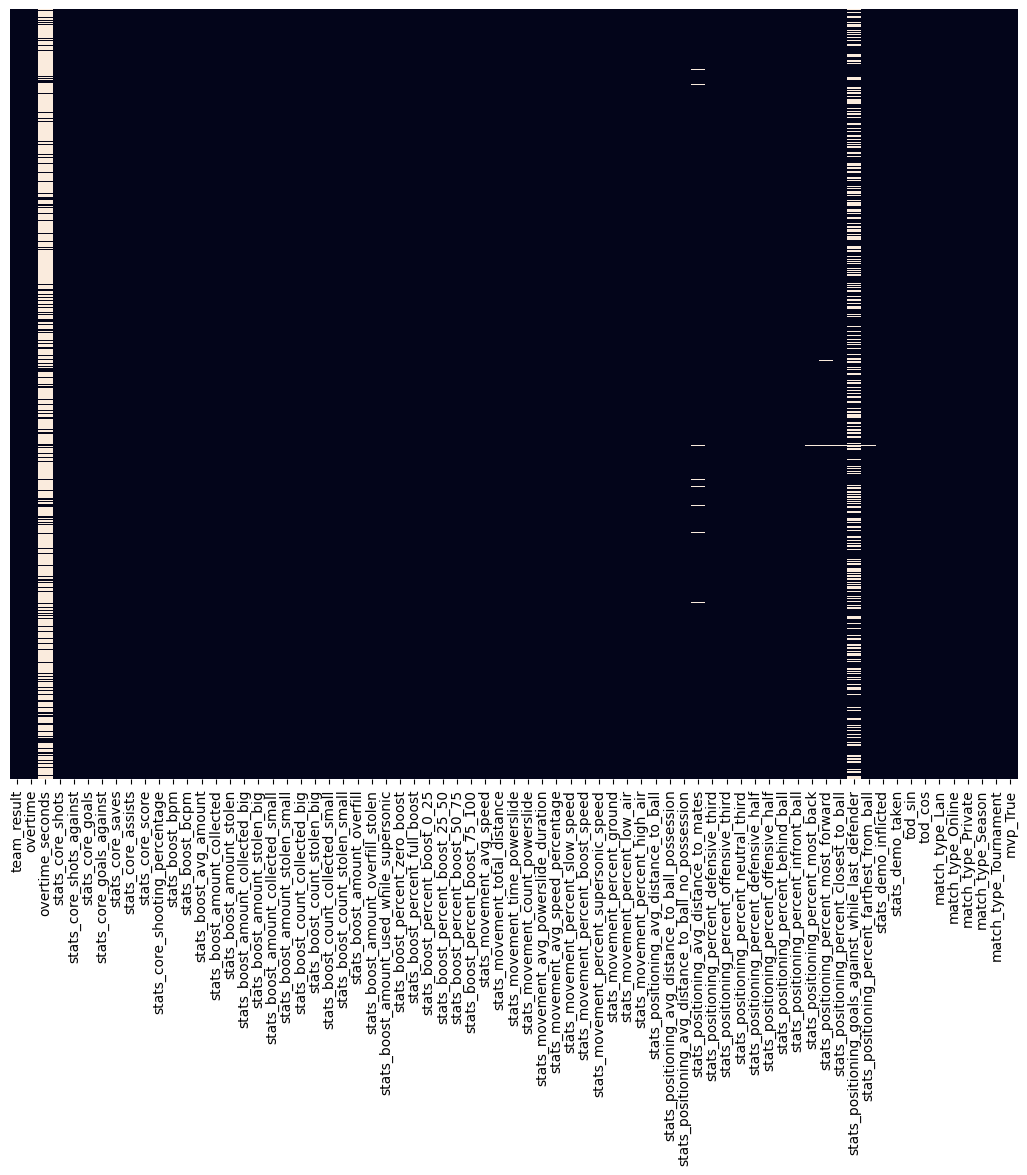

In [27]:
# Gesamtanzahl der Nullwerte berechnen
total_nulls = df_encoded.isnull().sum().sum()
print(f"Gesamtanzahl der Nullwerte im DataFrame: {total_nulls}")
plt.figure(figsize=(13, 10))
sns.heatmap(df_encoded.isnull(), cbar=False, yticklabels=False)
plt.show()

In [28]:
# Fehlende Werte mit 0 ersetzen
df_encoded = df_encoded.fillna(0)

In [29]:
df_encoded

,team_result,overtime,overtime_seconds,stats_core_shots,stats_core_shots_against,stats_core_goals,stats_core_goals_against,stats_core_saves,stats_core_assists,stats_core_score,stats_core_shooting_percentage,stats_boost_bpm,stats_boost_bcpm,stats_boost_avg_amount,stats_boost_amount_collected,stats_boost_amount_stolen,stats_boost_amount_collected_big,stats_boost_amount_stolen_big,stats_boost_amount_collected_small,stats_boost_amount_stolen_small,stats_boost_count_collected_big,stats_boost_count_stolen_big,stats_boost_count_collected_small,stats_boost_count_stolen_small,stats_boost_amount_overfill,stats_boost_amount_overfill_stolen,stats_boost_amount_used_while_supersonic,stats_boost_percent_zero_boost,stats_boost_percent_full_boost,stats_boost_percent_boost_0_25,stats_boost_percent_boost_25_50,stats_boost_percent_boost_50_75,stats_boost_percent_boost_75_100,stats_movement_avg_speed,stats_movement_total_distance,stats_movement_time_powerslide,stats_movement_count_powerslide,stats_movement_avg_powerslide_duration,stats_movement_avg_speed_percentage,stats_movement_percent_slow_speed,stats_movement_percent_boost_speed,stats_movement_percent_supersonic_speed,stats_movement_percent_ground,stats_movement_percent_low_air,stats_movement_percent_high_air,stats_positioning_avg_distance_to_ball,stats_positioning_avg_distance_to_ball_possession,stats_positioning_avg_distance_to_ball_no_possession,stats_positioning_avg_distance_to_mates,stats_positioning_percent_defensive_third,stats_positioning_percent_offensive_third,stats_positioning_percent_neutral_third,stats_positioning_percent_defensive_half,stats_positioning_percent_offensive_half,stats_positioning_percent_behind_ball,stats_positioning_percent_infront_ball,stats_positioning_percent_most_back,stats_positioning_percent_most_forward,stats_positioning_percent_closest_to_ball,stats_positioning_goals_against_while_last_defender,stats_positioning_percent_farthest_from_ball,stats_demo_inflicted,stats_demo_taken,tod_sin,tod_cos,match_type_Lan,match_type_Online,match_type_Private,match_type_Season,match_type_Tournament,mvp_True
0,1,True,11.0,4,10,2,2,6,0,879,50.000000,476,504.68756,49.69,2898,519,2158,310,740,209,27,5,66,19,556,195,549,13.865266,11.566482,34.124830,24.853006,16.417910,24.604250,1642,557986,8.88,99,0.09,71.391304,37.243855,38.911900,23.844242,51.416737,42.642914,5.940348,2383,2068,2606,3109.0,46.883540,18.491617,34.624836,65.462585,34.537422,79.950840,20.049156,47.049606,50.851887,51.258236,0.0,46.730328,0,0,-0.987229,-0.159307,False,True,False,False,False,True
1,1,True,11.0,4,10,1,2,0,0,327,25.000000,342,398.10757,53.56,2286,380,1562,205,724,175,20,4,68,15,477,196,192,3.680376,15.560329,22.286080,26.066458,18.488964,33.158497,1602,542475,6.81,52,0.13,69.652176,41.909367,43.169384,14.921249,59.577232,38.800774,1.621995,2483,2295,2595,3109.0,47.607075,16.507322,35.885605,70.315000,29.684996,77.551810,22.448190,50.938960,47.281803,46.875454,2.0,51.258236,1,0,-0.987229,-0.159307,False,True,False,False,False,False
2,0,True,11.0,6,8,2,3,3,0,760,33.333332,420,447.91455,45.04,2572,810,1796,542,776,268,22,6,69,23,209,57,86,14.892753,6.159115,41.320118,21.097654,14.799129,22.783092,1562,528098,9.11,95,0.10,67.913040,42.879242,41.558685,15.562062,56.426125,40.283460,3.290419,2097,1988,2196,2804.0,46.813270,23.858330,29.328398,62.507942,37.492060,75.006220,24.993784,45.830547,53.319016,52.970715,2.0,46.149826,0,0,-0.987229,-0.159307,False,True,False,False,False,False
3,0,True,11.0,4,8,0,3,3,2,510,0.000000,416,405.42188,44.65,2328,348,1670,176,658,172,18,2,58,16,149,41,261,17.487593,7.877398,43.332565,20.543060,14.870852,21.253525,1506,506552,3.85,48,0.08,65.478264,47.284637,40.814045,11.901310,56.830220,37.822693,5.347086,2357,2419,2332,2804.0,49.841090,18.907164,31.251741,69.375520,30.624475,74.248670,25.751326,53.493164,44.756626,45.250050,1.0,53.028763,0,1,-0.987229,-0.159307,False,True,False,False,False,False
4,0,False,0.0,12,9,4,5,3,0,1035,33.333332,460,467.73430,43.92,2799,560,2226,3

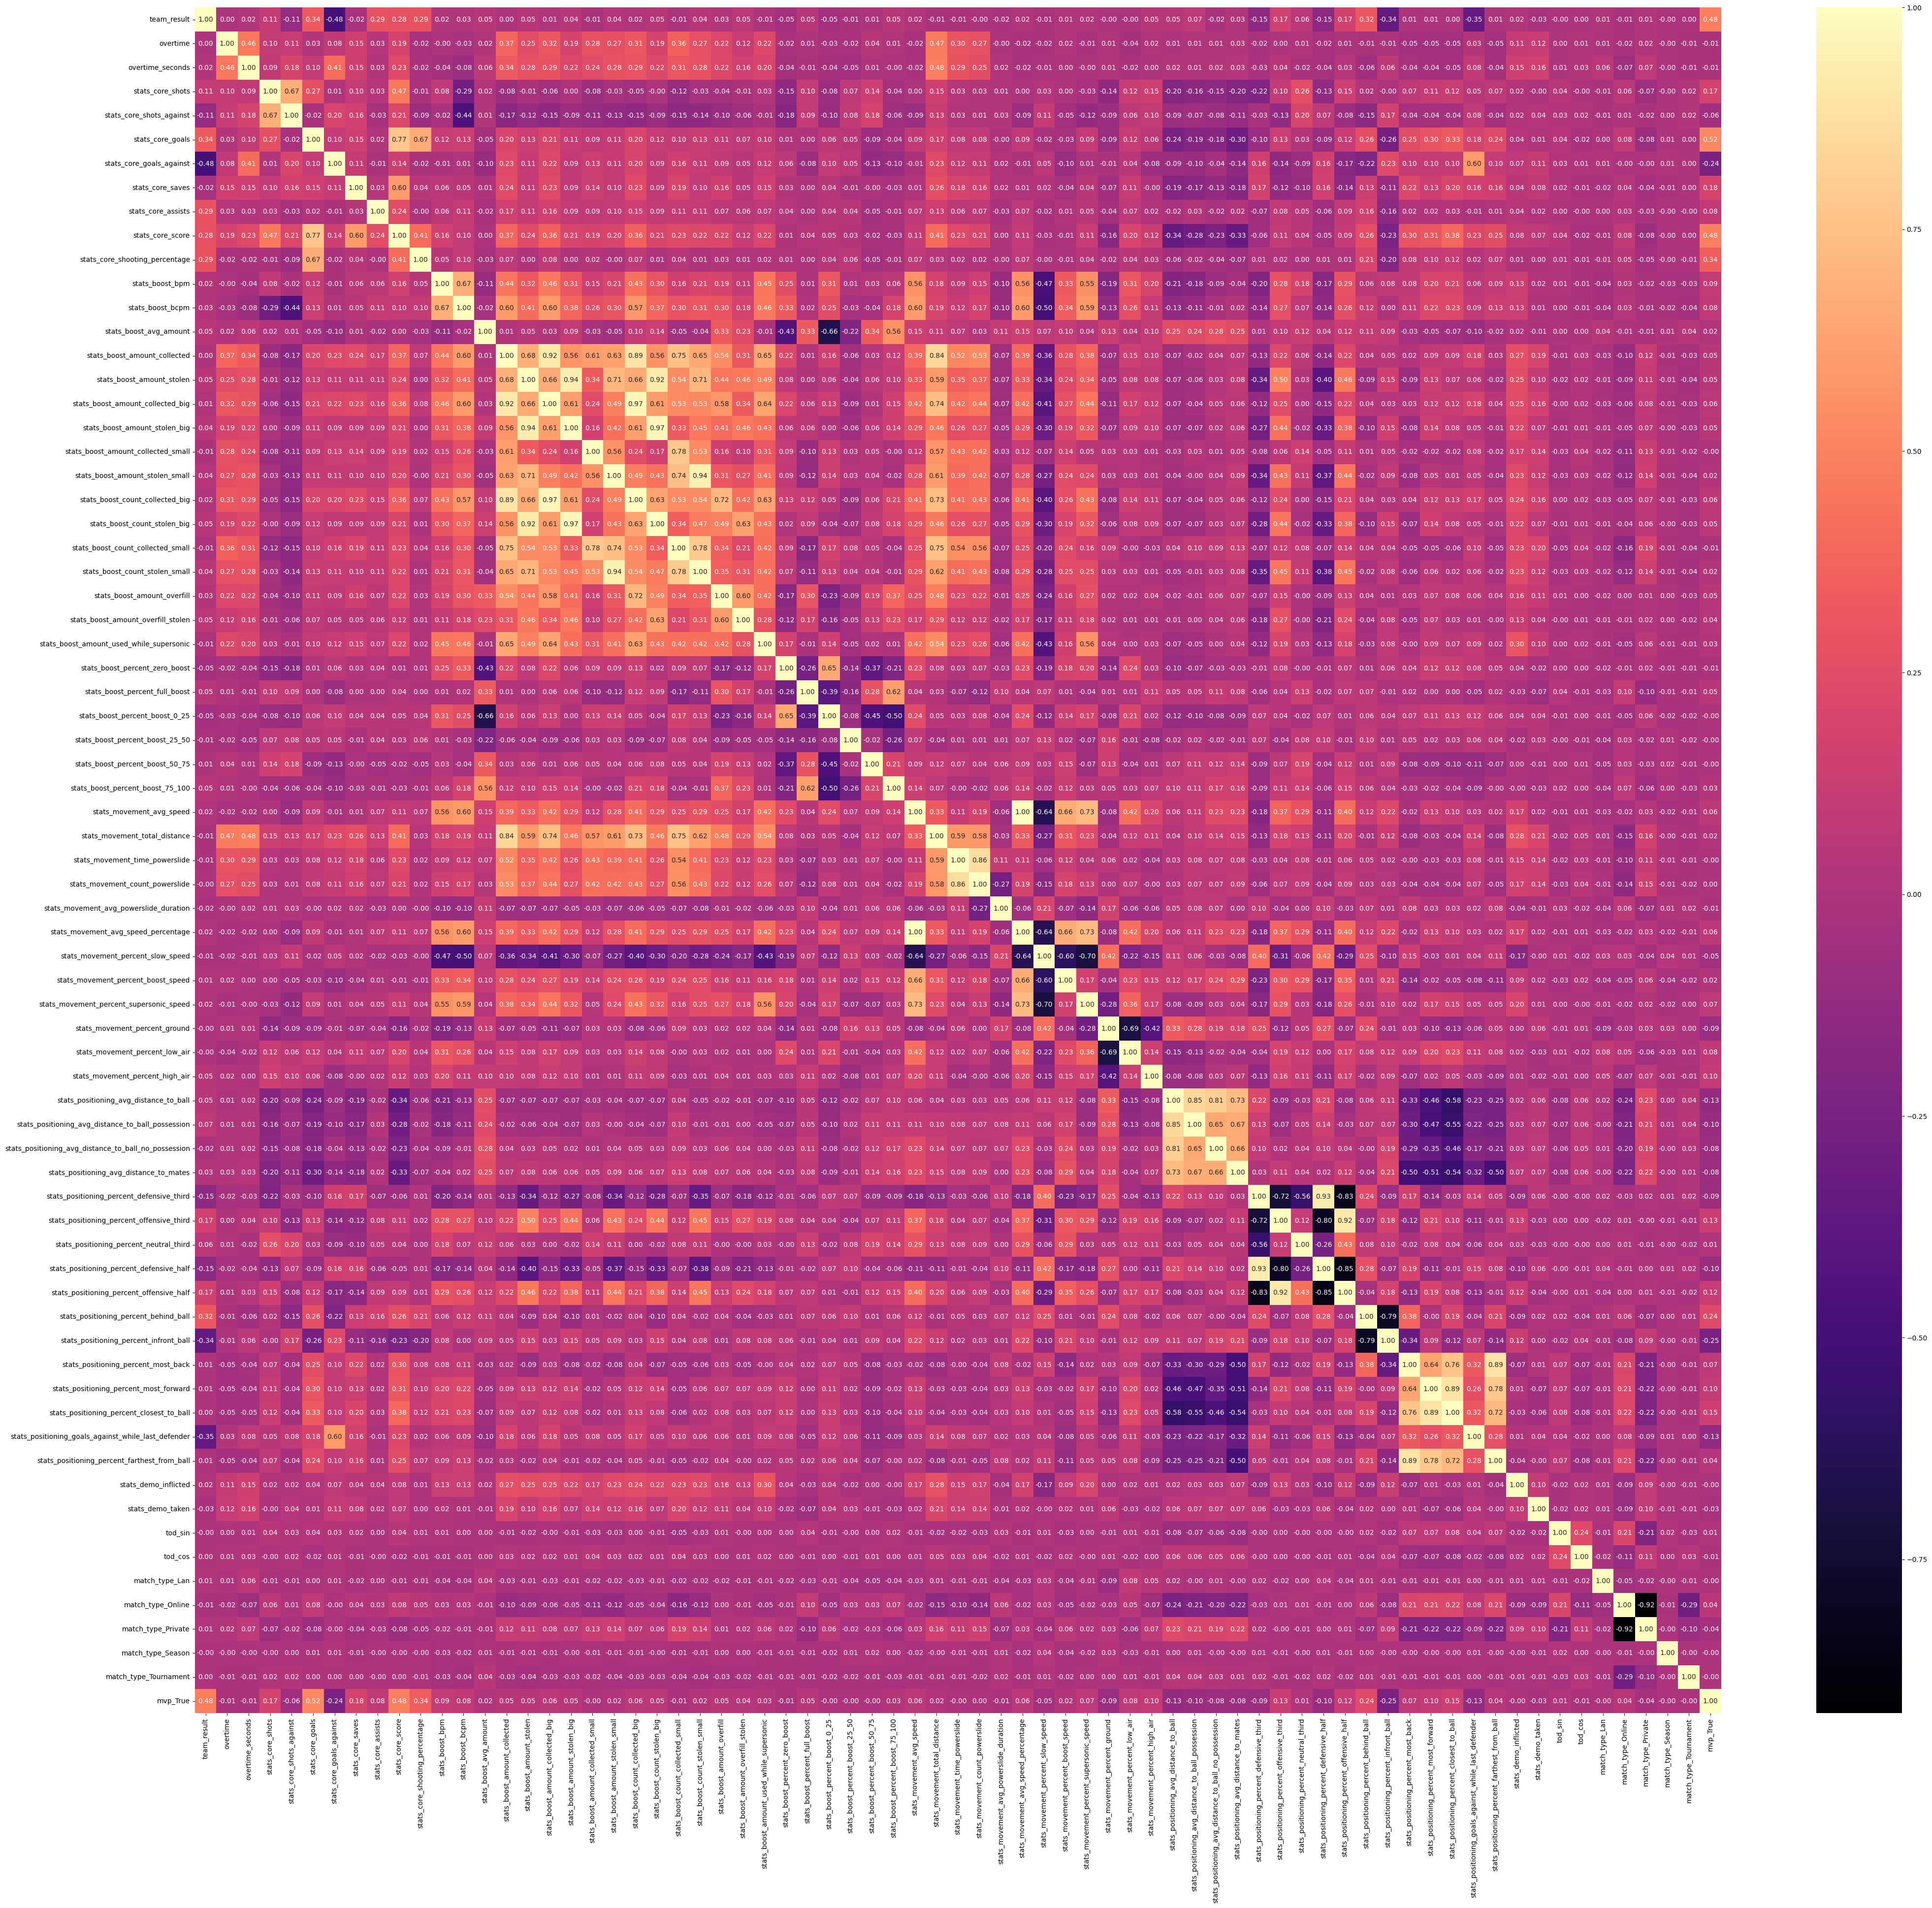

In [30]:
plt.figure(figsize=(50,45))
sns.heatmap(df_encoded.corr(), annot=True, fmt=".2f", cmap='magma')
plt.show()

In [31]:
# Annahme: df ist dein DataFrame mit allen Features
# Wähle numerische Spalten (int, float)
num_cols = df_encoded.select_dtypes(include=[np.number]).columns.tolist()

# Sammle Outlier-Statistiken
stats = []
for col in num_cols:
    series = df[col].dropna()
    # IQR-Methode
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outlier_iqr = series[(series < lower) | (series > upper)]
    pct_iqr = len(outlier_iqr) / len(series) * 100

    # Z-Score-Methode
    mean = series.mean()
    std = series.std()
    z_scores = (series - mean).abs() / std
    outlier_z = series[z_scores > 3]
    pct_z = len(outlier_z) / len(series) * 100

    stats.append({
        'feature': col,
        'n_missing': df[col].isna().sum(),
        'pct_missing': df[col].isna().mean() * 100,
        'outliers_IQR_%': pct_iqr,
        'outliers_Z_%': pct_z
    })

outlier_df = pd.DataFrame(stats).sort_values('outliers_IQR_%', ascending=False)

# Anzeige der Ergebnisse
print(outlier_df)
# Optional: interaktive Tabelle, falls unterstützt
# import ace_tools as tools; tools.display_dataframe_to_user("Outlier-Analyse", outlier_df)


                                                feature  n_missing  pct_missing  outliers_IQR_%  outliers_Z_%
33                        stats_movement_total_distance          0     0.000000       14.039982      2.067204
60                                 stats_demo_inflicted          0     0.000000        7.918434      0.774221
61                                     stats_demo_taken          0     0.000000        7.200340      2.016029
13                         stats_boost_amount_collected          0     0.000000        6.256087      2.494346
58  stats_positioning_goals_against_while_last_defender      92397    38.132047        5.906838      2.113254
..                                                  ...        ...          ...             ...           ...
4                                      stats_core_goals          0     0.000000        0.597587      1.349109
9                        stats_core_shooting_percentage          0     0.000000        0.441999      0.441999
5         

In [32]:
from sklearn.preprocessing import MinMaxScaler
import joblib  # für Speichern und Laden des Scalers

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_encoded[con_ft])
joblib.dump(scaler, 'robust_scaler.joblib')


['robust_scaler.joblib']

In [33]:
df_scaled

array([[0.5       , 0.00319118, 0.03007519, ..., 0.        , 0.00638545,
        0.42034656],
       [0.5       , 0.00319118, 0.03007519, ..., 0.        , 0.00638545,
        0.42034656],
       [0.        , 0.00319118, 0.04511278, ..., 0.        , 0.00638545,
        0.42034656],
       ...,
       [0.        , 0.        , 0.01503759, ..., 0.        , 0.02146656,
        0.64493355],
       [0.        , 0.        , 0.02255639, ..., 0.05555556, 0.02146656,
        0.64493355],
       [0.        , 0.        , 0.01503759, ..., 0.05555556, 0.02146656,
        0.64493355]])

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# X: dein bereits skalierter numerischer DataFrame (z. B. df_scaled[num_cols])
X = df_scaled.copy()

# Finde optimale Clusterzahl mit Silhouette-Score
scores = []
for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X)
    score = silhouette_score(X, labels)
    scores.append(score)

plt.plot(range(2, 8), scores, marker='o')
plt.xlabel('Anzahl Cluster')
plt.ylabel('Silhouette Score')
plt.title('Cluster-Qualität')
plt.show()

# Wir nehmen z. B. k=4
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X)
joblib.dump(kmeans, 'kmeans_playstyles.pkl')


In [39]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# --- 1) Skalieren wie gehabt ---
scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(df_encoded)
X_scaled = pd.DataFrame(X_scaled_array, columns=df_encoded.columns)

# Scaler speichern
joblib.dump(scaler, 'standard_scaler_cluster.joblib')

# --- 2) KMeans fitten ---
n_clusters_soll = 4
kmeans = KMeans(
    n_clusters=n_clusters_soll,
    init='k-means++',
    n_init='auto',
    random_state=42
)
kmeans.fit(X_scaled)
print("K-Means-Clustering abgeschlossen.")

# --- 3) Distances und weiche Wahrscheinlichkeiten berechnen ---
# distances[i,j] = Abstand von Sample i zu Cluster-Zentrum j
distances = kmeans.transform(X_scaled)

# Umkehr der Distanzen (je näher, desto größer die Stärke)
eps = 1e-6
strengths = 1.0 / (distances + eps)

# Normiere auf Summe=1 pro Sample → „Wahrscheinlichkeiten“
probs = strengths / strengths.sum(axis=1, keepdims=True)

# Spaltennamen für Probabilities
prob_cols = [f'prob_cluster_{i}' for i in range(n_clusters_soll)]

# DataFrame der Wahrscheinlichkeiten
df_probs = pd.DataFrame(probs, columns=prob_cols, index=df_encoded.index)

# --- 4) In DataFrame mergen ---
X_with_clusters = df_encoded.copy()
X_with_clusters['hard_label'] = kmeans.labels_
X_with_clusters = pd.concat([X_with_clusters, df_probs], axis=1)

print("\nBeispiel `X_with_clusters` mit Wahrscheinlichkeiten:")
print(X_with_clusters.head())

# --- 5) Jetzt kannst du z.B. beschreibende Statistiken gewichtet nach maximaler Wahrscheinlichkeit machen ---
feature_columns = [c for c in df_encoded.columns]
clusters_summary = {}

print("\nGewichtete Mittelwerte pro Cluster (soft assignment):")
for i in range(n_clusters_soll):
    w = X_with_clusters[f'prob_cluster_{i}']
    # gewichteter Mittelwert
    weighted_means = (X_with_clusters[feature_columns].multiply(w, axis=0)).sum() / w.sum()
    clusters_summary[i] = weighted_means.to_dict()
    print(f"\n--- Cluster {i} ---")
    print(weighted_means)
    

# Und du kannst natürlich auch Boxplots über hard_label darstellen wie gehabt...


K-Means-Clustering abgeschlossen.

Beispiel `X_with_clusters` mit Wahrscheinlichkeiten:
   team_result  overtime  overtime_seconds  stats_core_shots  stats_core_shots_against  stats_core_goals  stats_core_goals_against  stats_core_saves  stats_core_assists  stats_core_score  stats_core_shooting_percentage  stats_boost_bpm  stats_boost_bcpm  stats_boost_avg_amount  stats_boost_amount_collected  stats_boost_amount_stolen  stats_boost_amount_collected_big  stats_boost_amount_stolen_big  stats_boost_amount_collected_small  stats_boost_amount_stolen_small  stats_boost_count_collected_big  stats_boost_count_stolen_big  stats_boost_count_collected_small  stats_boost_count_stolen_small  stats_boost_amount_overfill  stats_boost_amount_overfill_stolen  stats_boost_amount_used_while_supersonic  stats_boost_percent_zero_boost  stats_boost_percent_full_boost  stats_boost_percent_boost_0_25  stats_boost_percent_boost_25_50  stats_boost_percent_boost_50_75  stats_boost_percent_boost_75_100  stats_mov

import pandas as pd
import numpy as np # Wird für die Beispieldatenerstellung benötigt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


scaler = StandardScaler()
joblib.dump(scaler, 'standard_scaler_cluster.joblib')
X_scaled_array = scaler.fit_transform(df_encoded)
X_scaled = pd.DataFrame(X_scaled_array, columns=df_encoded.columns)

print("Form der skalierten Features:", X_scaled.shape)

# 2. K-Means-Modell initialisieren und anpassen
#    n_clusters: Die Anzahl der zu findenden Cluster (in Ihrem Fall 4)
#    init='k-means++': Eine intelligente Methode zur Initialisierung der Clusterzentren, verbessert oft die Ergebnisse.
#    n_init='auto' (oder eine Zahl wie 10): Anzahl der Male, die der K-Means-Algorithmus mit unterschiedlichen
#                                Centroid-Seeds ausgeführt wird. Das Endergebnis ist das beste Ergebnis dieser Läufe.
#    random_state: Für Reproduzierbarkeit.
n_clusters_soll = 4
kmeans = KMeans(n_clusters=n_clusters_soll, init='k-means++', n_init='auto', random_state=42)

print(f"\nStarte K-Means-Clustering mit {n_clusters_soll} Clustern...")
kmeans.fit(X_scaled)
print("K-Means-Clustering abgeschlossen.")

cluster_labels = kmeans.labels_

# Füge Cluster-Labels zu den Original-Features hinzu (für die Visualisierung in Originalskala)
X_with_clusters = df_encoded.copy() # Kopie der Original-Features
X_with_clusters['Cluster'] = cluster_labels
# --- Ende der Wiederholung ---


# 1. Vorbereitung der Daten für die Visualisierung
#    Das DataFrame `X_with_clusters` enthält nun die Original-Feature-Werte und die Cluster-Zuweisung.

# 2. Erstellung der Boxplots für jedes Feature pro Cluster
feature_columns = [col for col in X_with_clusters.columns if col != 'Cluster']
num_features = len(feature_columns)

print(f"\nErstelle Boxplots für {num_features} Features, gruppiert nach {n_clusters_soll} Clustern...")

# Bestimme die Anzahl der Zeilen und Spalten für die Subplots
# Ziel: Möglichst quadratische Anordnung
cols_subplot = int(np.ceil(np.sqrt(num_features)))
rows_subplot = int(np.ceil(num_features / cols_subplot))

fig, axes = plt.subplots(rows_subplot, cols_subplot, figsize=(cols_subplot * 5, rows_subplot * 4))
axes = axes.flatten() # Um die Achsen einfach zu iterieren, auch wenn nur eine Zeile/Spalte

for i, feature_name in enumerate(feature_columns):
    ax = axes[i]
    sns.boxplot(x='Cluster', y=feature_name, data=X_with_clusters, ax=ax, palette='viridis')
    ax.set_title(f'Verteilung von {feature_name} pro Cluster')
    ax.set_xlabel('Cluster')
    ax.set_ylabel(feature_name)
    ax.grid(True, linestyle='--', alpha=0.7)

# Verstecke ungenutzte Subplots, falls vorhanden
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout() # Passt Subplots an, um Überlappungen zu vermeiden
plt.suptitle(f'Bandbreite der Features pro Cluster (N={len(X_with_clusters)})', fontsize=16, y=1.02) # Hauptüberschrift
plt.show()

# 3. Alternative: Violinplots (zeigen die Dichteverteilung besser)
print(f"\nErstelle Violinplots für {num_features} Features, gruppiert nach {n_clusters_soll} Clustern...")

fig_violin, axes_violin = plt.subplots(rows_subplot, cols_subplot, figsize=(cols_subplot * 5, rows_subplot * 4))
axes_violin = axes_violin.flatten()

for i, feature_name in enumerate(feature_columns):
    ax_v = axes_violin[i]
    sns.violinplot(x='Cluster', y=feature_name, data=X_with_clusters, ax=ax_v, palette='viridis', inner='quartile')
    # 'inner="quartile"' zeigt die Quartile innerhalb des Violinplots an
    # Alternativen: 'box', 'stick', 'point', None
    ax_v.set_title(f'Verteilung von {feature_name} pro Cluster (Violin)')
    ax_v.set_xlabel('Cluster')
    ax_v.set_ylabel(feature_name)
    ax_v.grid(True, linestyle='--', alpha=0.7)

for j in range(i + 1, len(axes_violin)):
    fig_violin.delaxes(axes_violin[j])

plt.tight_layout()
plt.suptitle(f'Bandbreite der Features pro Cluster (Violinplots, N={len(X_with_clusters)})', fontsize=16, y=1.02)
plt.show()

feature_columns = ['team_result', 'stats_core_goals', 'stats_core_goals_against', 'stats_core_saves', 'stats_core_assists', 'stats_core_score', 'stats_boost_amount_collected', 'stats_boost_amount_stolen', 'stats_movement_avg_speed_percentage', 'stats_positioning_avg_distance_to_ball', 'stats_positioning_percent_defensive_third', 'stats_positioning_percent_offensive_third', 'stats_positioning_percent_behind_ball', 'stats_demo_inflicted', 'stats_demo_taken']
clusters = {}
# 4. Zusammenfassende Statistiken pro Cluster (numerisch)
#    Dies kann helfen, die Visualisierungen zu ergänzen und die Cluster zu charakterisieren.
print("\nDeskriptive Statistiken der Features pro Cluster (Mittelwert, Standardabweichung, etc.):")
for cluster_id in sorted(X_with_clusters['Cluster'].unique()):
    print(f"\n--- Cluster {cluster_id} ---")
    # Verwenden Sie .loc, um Slicing-Warnungen zu vermeiden
    cluster_data = X_with_clusters.loc[X_with_clusters['Cluster'] == cluster_id, feature_columns]
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', None)
    print(cluster_data.describe().transpose()) # .transpose() für bessere Lesbarkeit
    clusters[cluster_id] = {}
    for ft in feature_columns:
        clusters[cluster_id][ft] = cluster_data[ft].mean()

In [44]:
clusters_summary

{0: {'team_result': 0.5158131383030636,
  'overtime': 0.2026263802382086,
  'overtime_seconds': 17.098986612399596,
  'stats_core_shots': 3.5651122166767824,
  'stats_core_shots_against': 8.815209305051187,
  'stats_core_goals': 1.0955319327900603,
  'stats_core_goals_against': 2.6235008137770857,
  'stats_core_saves': 1.543994318359754,
  'stats_core_assists': 0.650401001674883,
  'stats_core_score': 424.2411093297657,
  'stats_core_shooting_percentage': 31.100943205888402,
  'stats_boost_bpm': 400.33971489501124,
  'stats_boost_bcpm': 411.76626259212514,
  'stats_boost_avg_amount': 49.292412488091884,
  'stats_boost_amount_collected': 2263.4586871007436,
  'stats_boost_amount_stolen': 508.7236829718679,
  'stats_boost_amount_collected_big': 1591.7279006151578,
  'stats_boost_amount_stolen_big': 304.3373119509487,
  'stats_boost_amount_collected_small': 671.7307864855861,
  'stats_boost_amount_stolen_small': 204.38637102091926,
  'stats_boost_count_collected_big': 19.304789413522787,


In [69]:
import pandas as pd
import plotly.express as px

# 1) Definition der Features
features = [
    'team_result',
    'stats_core_goals',
    'stats_core_goals_against',
    'stats_core_saves',
    'stats_core_assists',
    'stats_core_score',
    'stats_boost_amount_collected',
    'stats_boost_amount_stolen',
    'stats_movement_avg_speed_percentage',
    'stats_positioning_avg_distance_to_ball',
    'stats_positioning_percent_defensive_third',
    'stats_positioning_percent_offensive_third',
    'stats_positioning_percent_behind_ball',
    'stats_demo_inflicted',
    'stats_demo_taken'
]

cluster_names_map = {
    0: 'Versatile Vanguard',
    1: 'Calculated Counter',
    2: 'Fortress Guardian',
    3: 'High-Octane Hunter'
}

# 2) Aus Dict ein DataFrame bauen
df_cluster = pd.DataFrame.from_dict(clusters_summary, orient='index')

# 3) Nur unsere 15 Features behalten
df_cluster = df_cluster[features]

# 4) Pro-Feature Min–Max-Skalierung
df_scaled = (df - df.min()) / (df.max() - df.min())

# 5) In langes Format „melt“ und sprechende Cluster-Namen mappen
df_long = (
    df_scaled
    .reset_index()                        # bringt cluster-IDs in Spalte „index“
    .rename(columns={'index':'cluster_id'})
    .melt(
        id_vars='cluster_id',
        value_vars=features,
        var_name='feature',
        value_name='value'
    )
)
df_long['cluster'] = df_long['cluster_id'].map(cluster_names_map)

# 6) Plotly Radar-Chart
fig = px.line_polar(
    df_long,
    r='value',
    theta='feature',
    color='cluster',
    line_close=True,
    markers=True,
    template='plotly_dark',
    title='Cluster Profiles (Feature-wise Min-Max Skaliert)',
    width=1300,
    height=800
)
fig.update_traces(fill='toself')
fig.update_layout(
    legend=dict(
        title='Spielstil-Cluster',
        itemsizing='constant'
    )
)
fig.show()


Versatile Vanguard
– Hohe Boost-Nutzung & -Diebstahl, starke Geschwindigkeit, viele Demolitions (inflicted & taken)
– Spielstil: Ein All‑Round‑Angreifer, der ständig im Offensivmodus ist, sich den Boost schnappt und jederzeit bereit ist, das Tempo anzuziehen oder Gegner vom Feld zu räumen.

Calculated Counter
– Erhöhte Ball‑Distanz (wartet ab), moderater Boost‑Einsatz, starker Fokus auf Konter (defensive Third %)
– Spielstil: Ein geduldiger Konter‑Spezialist, der sich defensiv positioniert und erst angreift, wenn der Gegner einen Fehler macht – ideal für saubere Gegenstöße.

Fortress Guardian
– Dominanz in der Defensive Third, geringere Offensivwerte, solide Saves
– Spielstil: Der unerschütterliche Torwart/Ball‑Wächter, der hinten alles dichtmacht und kaum einen Schuss auf sein Tor durchlässt.

High‑Octane Hunter
– Extrem hoher Score, viele Goals & Saves, agiert oft hinter dem Ball, aber bietet vielseitige Offensiv- und Support‑Aktionen
– Spielstil: Der energiegeladene Freigeist, der in jeder Phase präsent ist – schießt, rettet und assistiert mit maximaler Intensität.

In [57]:
# Zeigt alle Spalten (count, mean, std, etc.)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# --- Ausgabe in einen String-Puffer umleiten ---
output_buffer = io.StringIO()
output_buffer.write("Deskriptive Statistiken der Features pro Cluster (Mittelwert, Standardabweichung, etc.):\n")

for cluster_id in sorted(X_with_clusters['hard_label'].unique()):
    output_buffer.write(f"\n--- Cluster {cluster_id} ---\n")
    cluster_data = X_with_clusters.loc[X_with_clusters['hard_label'] == cluster_id, feature_columns]
    cluster_data.describe().transpose().to_string(buf=output_buffer)
    output_buffer.write("\n")

final_output = output_buffer.getvalue()

pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')
pd.reset_option('display.width')
pd.reset_option('display.max_colwidth')

file_name = "cluster_descriptive_statistics.txt"
try:
    with open(file_name, "w", encoding="utf-8") as f:
        f.write(final_output)
    print(f"\nDie deskriptiven Statistiken wurden erfolgreich in '{file_name}' gespeichert.")
except IOError as e:
    print(f"Fehler beim Speichern der Datei: {e}")




Die deskriptiven Statistiken wurden erfolgreich in 'cluster_descriptive_statistics.txt' gespeichert.


In [59]:
df_raw= df_raw.reset_index(drop=True)
X_with_clusters= X_with_clusters.reset_index(drop=True)

# 2. player_id ganz vorne einfügen
X_with_clusters.insert(0, 'player_id', df_raw['player_id'])

In [60]:
X_with_clusters

,player_id,team_result,overtime,overtime_seconds,stats_core_shots,stats_core_shots_against,stats_core_goals,stats_core_goals_against,stats_core_saves,stats_core_assists,...,match_type_Online,match_type_Private,match_type_Season,match_type_Tournament,mvp_True,hard_label,prob_cluster_0,prob_cluster_1,prob_cluster_2,prob_cluster_3
0,1,1,True,11.0,4,10,2,2,6,0,...,True,False,False,False,True,0,0.299855,0.236085,0.168221,0.295839
1,2,1,True,11.0,4,10,1,2,0,0,...,True,False,False,False,False,3,0.249881,0.270875,0.195908,0.283335
2,3,0,True,11.0,6,8,2,3,3,0,...,True,False,False,False,False,3,0.280780,0.234053,0.163493,0.321675
3,4,0,True,11.0,4,8,0,3,3,2,...,True,False,False,False,False,3,0.216375,0.264539,0.201570,0.317516
4,4,0,False,0.0,12,9,4,5,3,0,...,True,False,False,False,False,3,0.246609,0.229770,0.217797,0.305823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242303,23334,1,False,0.0,3,7,2,2,1,1,...,True,False,False,False,False,1,0.263894,0.285438,0.189321,0.261346
242304,23333,1,False,0.0,3,7,1,2,2,2,...,True,False,False,False,False,1,0.218030,0.304700,0.229987,0.247282
242305,4679,0,False,0.0,2,10,1,4,3,1,...,True,False,False,False,False,1,0.261160,0.279792,0.179948,0.279101
242306,28713,0,False,0.0,3,10,1,4,1,1,...,True,False,False,False,False,1,0.199233,0.302042,0.237168,0.261558


In [61]:
# Liste der Spalten mit den Soft‑Zugehörigkeiten
prob_cols = [c for c in X_with_clusters.columns if c.startswith('prob_cluster_')]

# 1) Gruppiere nach player_id und berechne Mean und Median
agg_mean   = X_with_clusters.groupby('player_id')[prob_cols].mean().add_suffix('_mean')
agg_median = X_with_clusters.groupby('player_id')[prob_cols].median().add_suffix('_median')

# 2) Fasse beides in einem DataFrame zusammen
player_probs = pd.concat([agg_mean, agg_median], axis=1).reset_index()

# Ausgabe
print(player_probs.head())


   player_id  prob_cluster_0_mean  prob_cluster_1_mean  prob_cluster_2_mean  \
0          0             0.250057             0.264005             0.209722   
1          1             0.296183             0.242134             0.164960   
2          2             0.270838             0.279629             0.190003   
3          3             0.258368             0.284132             0.195339   
4          4             0.233988             0.244519             0.222280   

   prob_cluster_3_mean  prob_cluster_0_median  prob_cluster_1_median  \
0             0.276216               0.241825               0.257476   
1             0.296723               0.291731               0.238730   
2             0.259530               0.294769               0.292968   
3             0.262161               0.257080               0.287273   
4             0.299213               0.226122               0.243572   

   prob_cluster_2_median  prob_cluster_3_median  
0               0.197289               0.2

In [63]:
player_probs[player_probs['player_id'] == 1687]

,player_id,prob_cluster_0_mean,prob_cluster_1_mean,prob_cluster_2_mean,prob_cluster_3_mean,prob_cluster_0_median,prob_cluster_1_median,prob_cluster_2_median,prob_cluster_3_median
1687,1687,0.251391,0.288815,0.199942,0.259851,0.245592,0.294743,0.194303,0.248624


In [64]:
player_probs.to_csv('player_probs.csv', index=False)